In [16]:
# import the packages needed for plotting
#!pip install FLowCal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mc
import colorsys
import os
import FlowCal

path = r"C:/Users/Emma Jones/OneDrive - University of Cambridge/Documents/My work/cambridge/Year 2/Rayner lab/Data/Invasion assay flow cytrometry/EEJR0153_2023.05.19 antibody binding assay correct"

BIN_COUNT = 10000
KEY = "BL1-A"

dark_colours = {

    'RCB': '#011A38',
    'anti-mouse': '#007FFA',
    'anti-rabbit':'#007FFA',
    'anti-CD55':'#97B6DA',
    'anti-PKH': '#A3BABE',
    'anti-CR1 E11':'#C6545E',
    #'Anti-CR1 ABIN':'#B4E0D4',
    'anti-CD147':'#7E7C9C',
    'anti-GYPA':'#91D4CF',
    'anti-GYPC':'#35BEB4',
    'anti-CR1 ABIN':'#C6545E',
}


colors = dark_colours

# A-D is in blood form 4.5.2023 AB+
# E-H is in blood from 2.5.2023 AB+

# repeats: a123, b123, a456,
conditoins = {
    'A1' : 'RCB',
    'A4' : 'anti-mouse',
    'A7' : 'anti-rabbit',
    'B1' : 'anti-CD55', 
    'B4' : 'anti-PKH',
    'C1' : 'anti-CR1 E11',
    'C4' : 'anti-CD147',
    'C7' : 'anti-GYPA',
    'C10': 'anti-GYPC',
    'D1' : 'anti-CR1 ABIN', # only two repeats, D1, D2
}

# add repeat columns + second half of plate

# all blood combined 
well_to_condition = {f'{chr(ord(k[0]) + j*4)}{int(k[1:])+i}':v for j in range(2) for k,v in conditoins.items() for i in range(3)} # all wells

# BLood A-D is in blood form 4.5.2023 AB+ donour 1
#well_to_condition = {f'{chr(ord(k[0]) + 0*4)}{int(k[1:])+i}':v for k,v in conditoins.items() for i in range(3)} # A-D

# BLood E-H is in blood from 2.5.2023 AB+ donor 2
#well_to_condition = {f'{chr(ord(k[0]) + 1*4)}{int(k[1:])+i}':v for k,v in conditoins.items() for i in range(3)} # E-H


def inverse_dict_with_lists(dictionary):
    inverse_dict = {}
    for key, value in dictionary.items():
        inverse_dict.setdefault(value, []).append(key)
    return inverse_dict

condition_to_well = inverse_dict_with_lists(well_to_condition)

print(well_to_condition)
print(condition_to_well)

#bin_edges = np.logspace(np.log10(1), np.log10(1e5), num=BIN_COUNT)
BIN_EDGES = np.linspace(-1e4,1e5,BIN_COUNT)
BIN_CENTERS = 0.5 * (BIN_EDGES[1:] + BIN_EDGES[:-1])


{'A1': 'RCB', 'A2': 'RCB', 'A3': 'RCB', 'A4': 'anti-mouse', 'A5': 'anti-mouse', 'A6': 'anti-mouse', 'A7': 'anti-rabbit', 'A8': 'anti-rabbit', 'A9': 'anti-rabbit', 'B1': 'anti-CD55', 'B2': 'anti-CD55', 'B3': 'anti-CD55', 'B4': 'anti-PKH', 'B5': 'anti-PKH', 'B6': 'anti-PKH', 'C1': 'anti-CR1 E11', 'C2': 'anti-CR1 E11', 'C3': 'anti-CR1 E11', 'C4': 'anti-CD147', 'C5': 'anti-CD147', 'C6': 'anti-CD147', 'C7': 'anti-GYPA', 'C8': 'anti-GYPA', 'C9': 'anti-GYPA', 'C10': 'anti-GYPC', 'C11': 'anti-GYPC', 'C12': 'anti-GYPC', 'D1': 'anti-CR1 ABIN', 'D2': 'anti-CR1 ABIN', 'D3': 'anti-CR1 ABIN', 'E1': 'RCB', 'E2': 'RCB', 'E3': 'RCB', 'E4': 'anti-mouse', 'E5': 'anti-mouse', 'E6': 'anti-mouse', 'E7': 'anti-rabbit', 'E8': 'anti-rabbit', 'E9': 'anti-rabbit', 'F1': 'anti-CD55', 'F2': 'anti-CD55', 'F3': 'anti-CD55', 'F4': 'anti-PKH', 'F5': 'anti-PKH', 'F6': 'anti-PKH', 'G1': 'anti-CR1 E11', 'G2': 'anti-CR1 E11', 'G3': 'anti-CR1 E11', 'G4': 'anti-CD147', 'G5': 'anti-CD147', 'G6': 'anti-CD147', 'G7': 'anti-GYP

In [17]:
def gate_rbcs(s: FlowCal.io.FCSData, show_plot=False) -> FlowCal.io.FCSData:
    xkey, ykey = 'FSC-A', 'SSC-A'
    XLIM = (0.01e6, 0.8e6) # min, max
    YLIM = (0, 0.25e6)

    s = FlowCal.gate.high_low(s, channels=[xkey, ykey]) # removes saturated datapoints

    keep_x = np.logical_and(XLIM[0] < s[:,xkey],  s[:,xkey] < XLIM[1]) 
    keep_y = np.logical_and(YLIM[0] < s[:,ykey],  s[:,ykey] < YLIM[1]) 
    keep = np.logical_and(keep_x, keep_y)
    s_gated = s[keep]

    if show_plot:
        plt.figure()
        FlowCal.plot.density2d(s, channels=[xkey, ykey], mode='scatter',xscale='linear', yscale='linear')
        plt.title('Before RBC gating')
        
        plt.figure()
        FlowCal.plot.density2d(s_gated, channels=[xkey, ykey], mode='scatter',xscale='linear', yscale='linear')
        plt.title('After RBC gating')

    return s_gated

def gate_singlets(s: FlowCal.io.FCSData, show_plot: bool = False) -> FlowCal.io.FCSData:
    xkey, ykey = 'FSC-A', 'FSC-H'
    #s_gated = FlowCal.gate.density2d(s, channels=[xkey, ykey], gate_fraction=0.8)

    def f(x):
        return 0.9 * x - 0.1e6
    
    keep = f(s[:, xkey]) < s[:, ykey]
    s_gated = s[keep]

    if show_plot:
        plt.figure()
        FlowCal.plot.density2d(s, channels=[xkey, ykey], mode='scatter', xscale='linear', yscale='linear')
        plt.title('Before singlet gating')

        plt.figure()
        FlowCal.plot.density2d(s_gated, channels=[xkey, ykey], mode='scatter', xscale='linear', yscale='linear')
        plt.title('After singlet gating')
    
    return s_gated

def normalize_histogram(hist):
    """Normalize a histogram by dividing bin heights by the sum of all bin heights."""
    return hist / np.sum(hist)


from collections import defaultdict
data = defaultdict(list)

for name in os.listdir(path):

    well = name.split("_")[-1].split('.')[0]

    if well not in well_to_condition:
        print('Not including', well)
        continue

    condition = well_to_condition[well]
    filename = os.path.join(path,name)
    s = FlowCal.io.FCSData(filename)
    s = FlowCal.transform.to_rfi(s) 

    # isloate all the RBCs SSC-A vs FSCA (square)
    s = gate_rbcs(s, show_plot=False)

    # isloate the singlets FSC-H vs FSC-A (parellel line)
    s = gate_singlets(s, show_plot=False)
    
    hist, bins = np.histogram(s[:, KEY], bins=BIN_EDGES, density=False)

    # Normalise y-axis by total number of counts 
    hist_norm = normalize_histogram(hist)
    
    data[condition].append({
        'filename': filename,
        'hist': hist, 
        'hist_norm': hist_norm,
        'bins': bins,
        'well': well
    })


<Figure size 3600x2700 with 0 Axes>

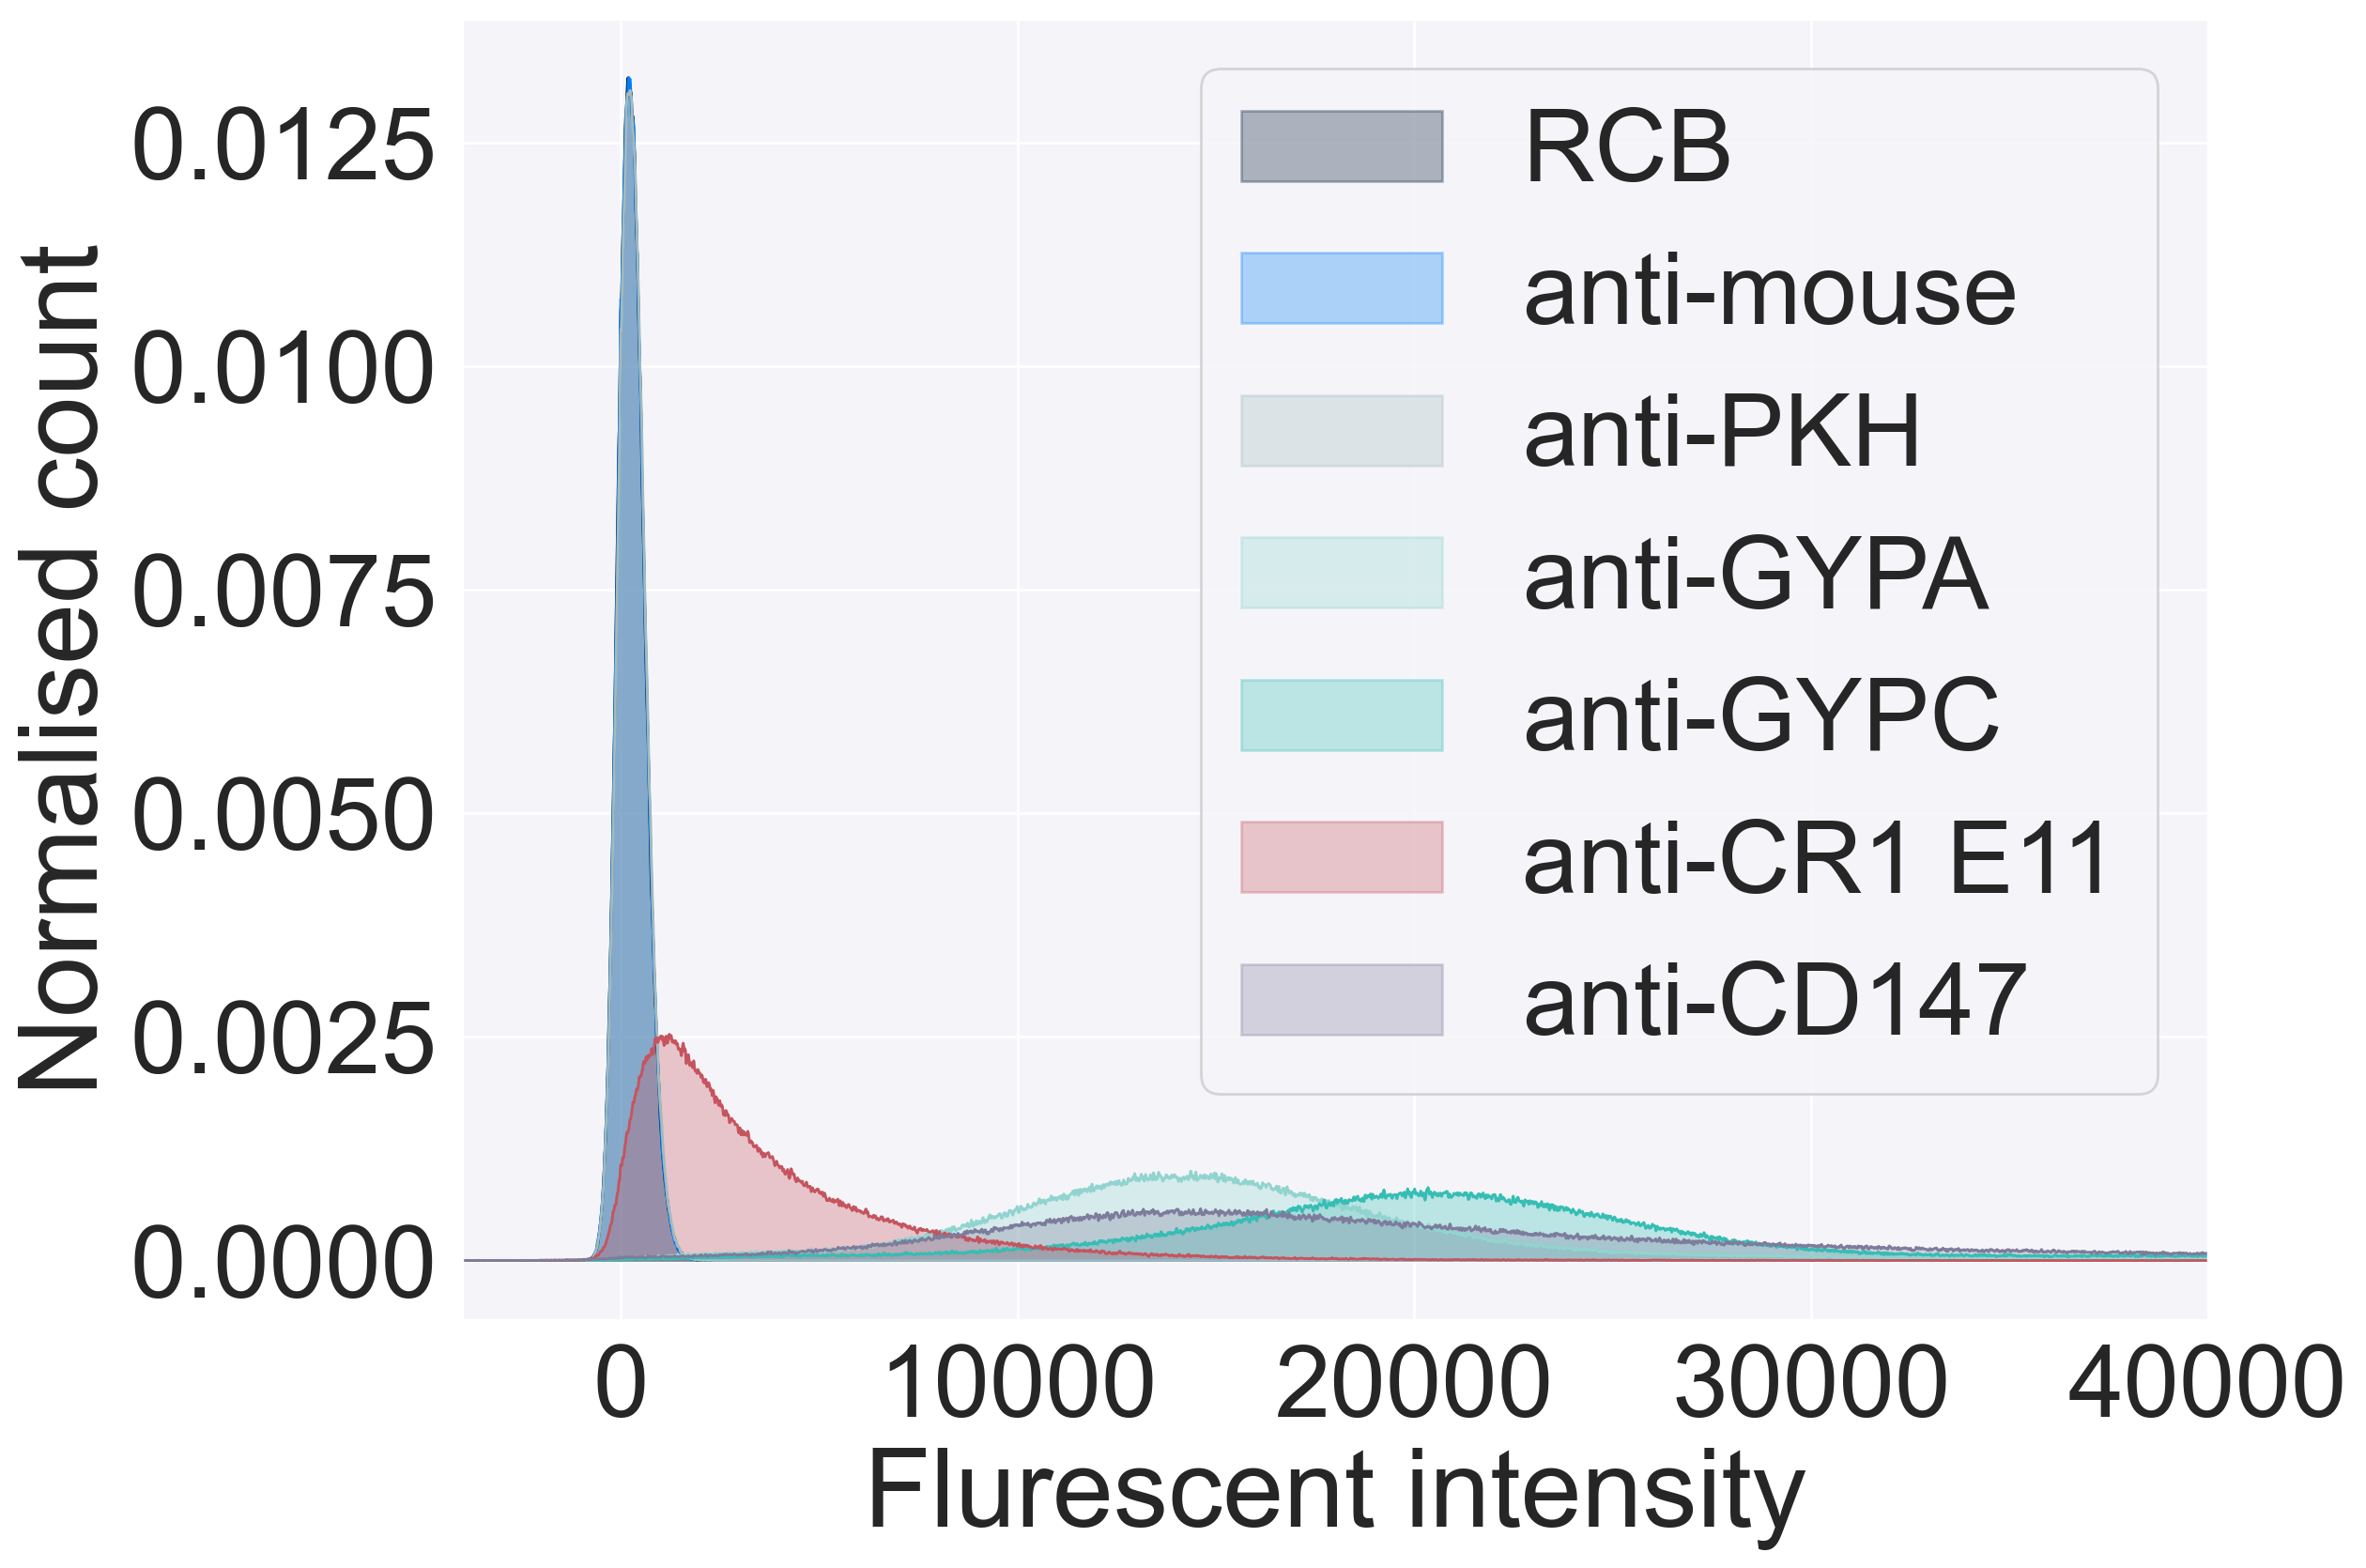

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

#plt.gcf().set_size_inches(4,9)
plt.gcf().set_size_inches(12,9)
plt.gcf().set_dpi(300)

def average_histograms(histograms, bin_edges_list, common_bin_edges):
    num_histograms = len(histograms)

    # Create an interpolating function for each histogram
    interpolators = []
    for i, hist in enumerate(histograms):
        bin_edges = bin_edges_list[i]
        interpolator = interp1d(bin_edges[:-1], hist, kind='linear', fill_value=(0, 0), bounds_error=False)
        interpolators.append(interpolator)

    # Resample each histogram onto the common bin edges
    resampled_histograms = []
    for interpolator in interpolators:
        resampled_hist = interpolator(common_bin_edges)
        resampled_histograms.append(resampled_hist)

    # Compute the average histogram
    avg_hist = np.sum(resampled_histograms, axis=0) / num_histograms
    return avg_hist


def compute_average_histogram(repeats, bin_edges):
    histograms = [r['hist_norm'] for r in repeats]
    bin_edges_list = [r['bins'] for r in repeats]
    return average_histograms(histograms=histograms, bin_edges_list=bin_edges_list, common_bin_edges=bin_edges)

def plot_smooth_histogram(histograms, key_list, title, xlabel=KEY, xlim=None, colors=colors):

    if not isinstance(histograms, list):
        series_list = [histograms]
    num_series = len(histograms)

# sets style of the graph, key consistent 
    plt.figure(figsize=(12, 9), dpi=200)
    sns.set_theme(context='notebook', 
              #style='darkgrid', 
              font='arial', 
              font_scale=3.5, 
              color_codes=True, 
              rc=None)
    sns.set_style(rc = {'axes.facecolor': '#F5F5F9'})
    

    for key, hist in zip(key_list, histograms):
        smoothed_hist = np.convolve(hist, np.hanning(5), mode='same') / np.sum(np.hanning(5))

        plt.plot(BIN_CENTERS, smoothed_hist, color=colors[key], linewidth=1)
        plt.fill_between(BIN_CENTERS, smoothed_hist, alpha=0.3, color=colors[key], label=key)

    plt.xlabel('Flurescent intensity')
    plt.ylabel('Normalised count')
    plt.title(title)
    plt.legend()
    if xlim != None: plt.xlim(xlim)
    #plt.xscale('logit')
    
   

def plot_smooth_histogram_from_repeats(data, key_list, **kwargs):
    histograms = [compute_average_histogram(repeats=data[key], bin_edges=BIN_CENTERS) for key in key_list]
    plot_smooth_histogram(histograms=histograms, key_list=key_list, **kwargs)


plot_smooth_histogram_from_repeats(
    data=data, 
    key_list=['RCB', 'anti-mouse', 'anti-PKH', 'anti-GYPA','anti-GYPC', 'anti-CR1 E11', 'anti-CD147'],
    #key_list=['anti-mouse','anti-CR1 E11','anti-CR1 ABIN'],
    #key_list=['anti-mouse','anti-CR1 E11'],
    xlim=(-4e3, 4e4),
    #title='Donor 1',
    title='',
)


plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(f'graphs/antibody binding3.svg', bbox_inches='tight')
#plt.savefig(f'graphs/antibody.pdf', bbox_inches='tight')
#plt.savefig(f'graphs/antibody.pdf')

plt.show()


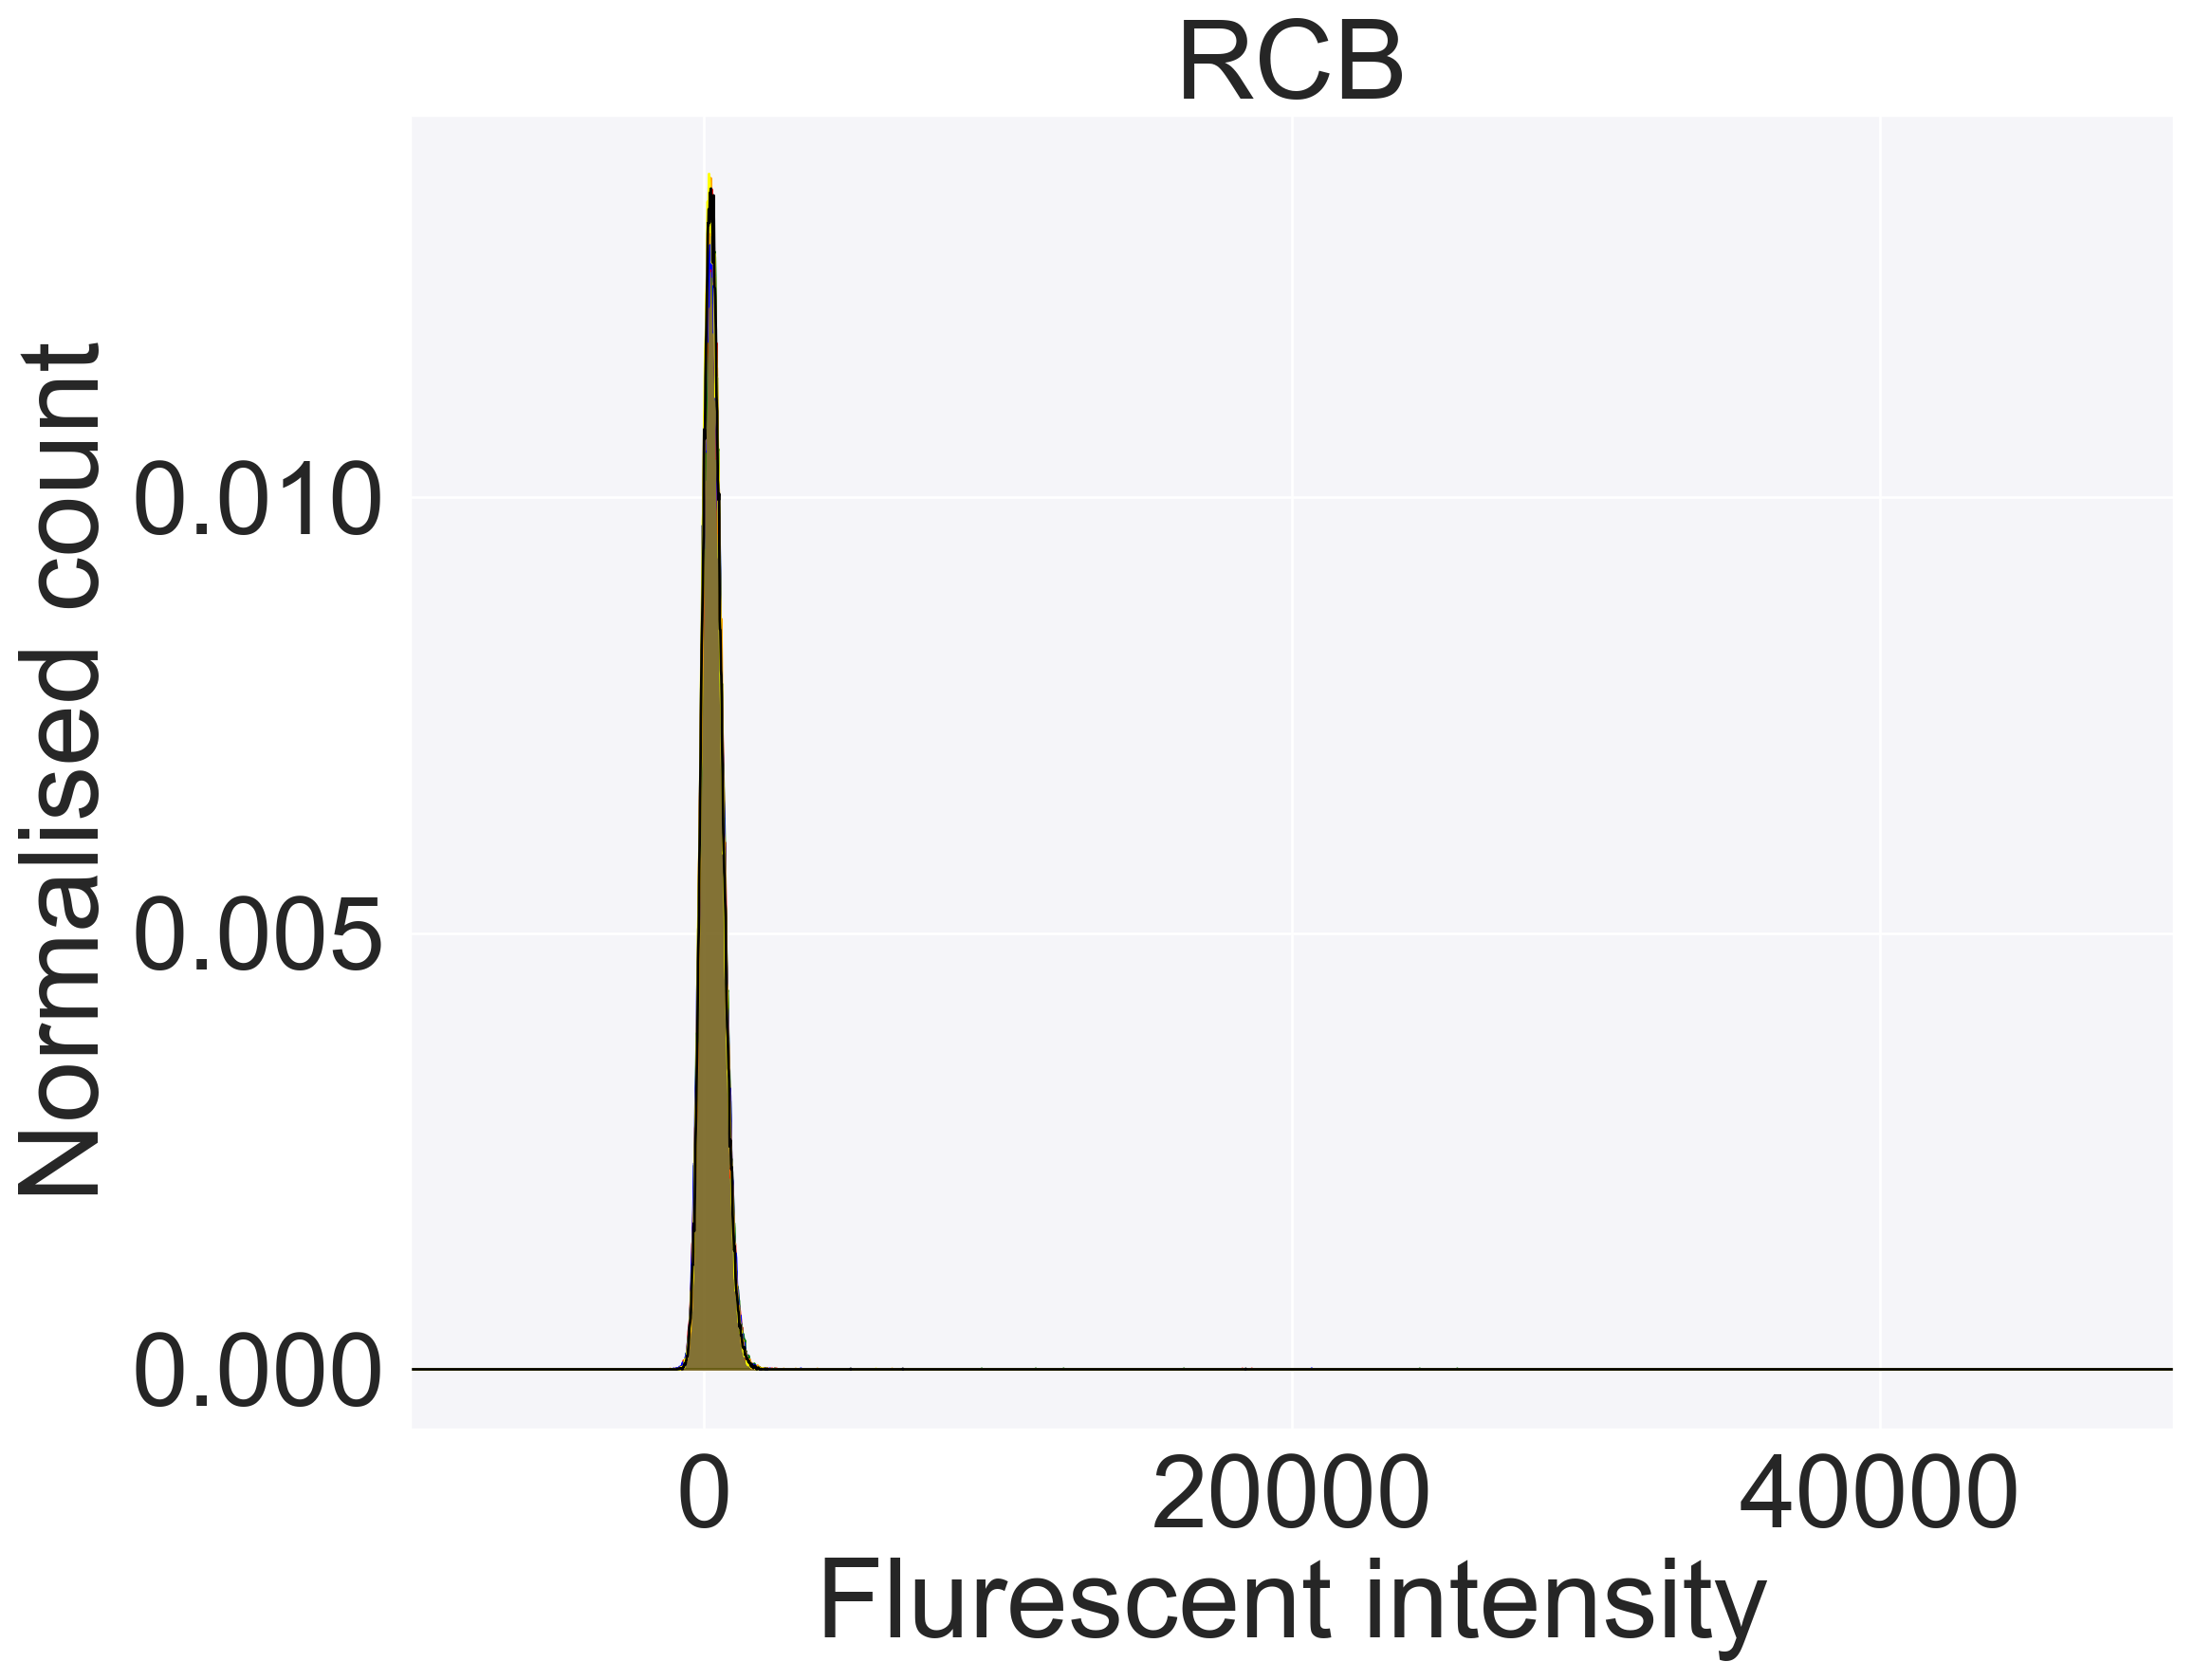

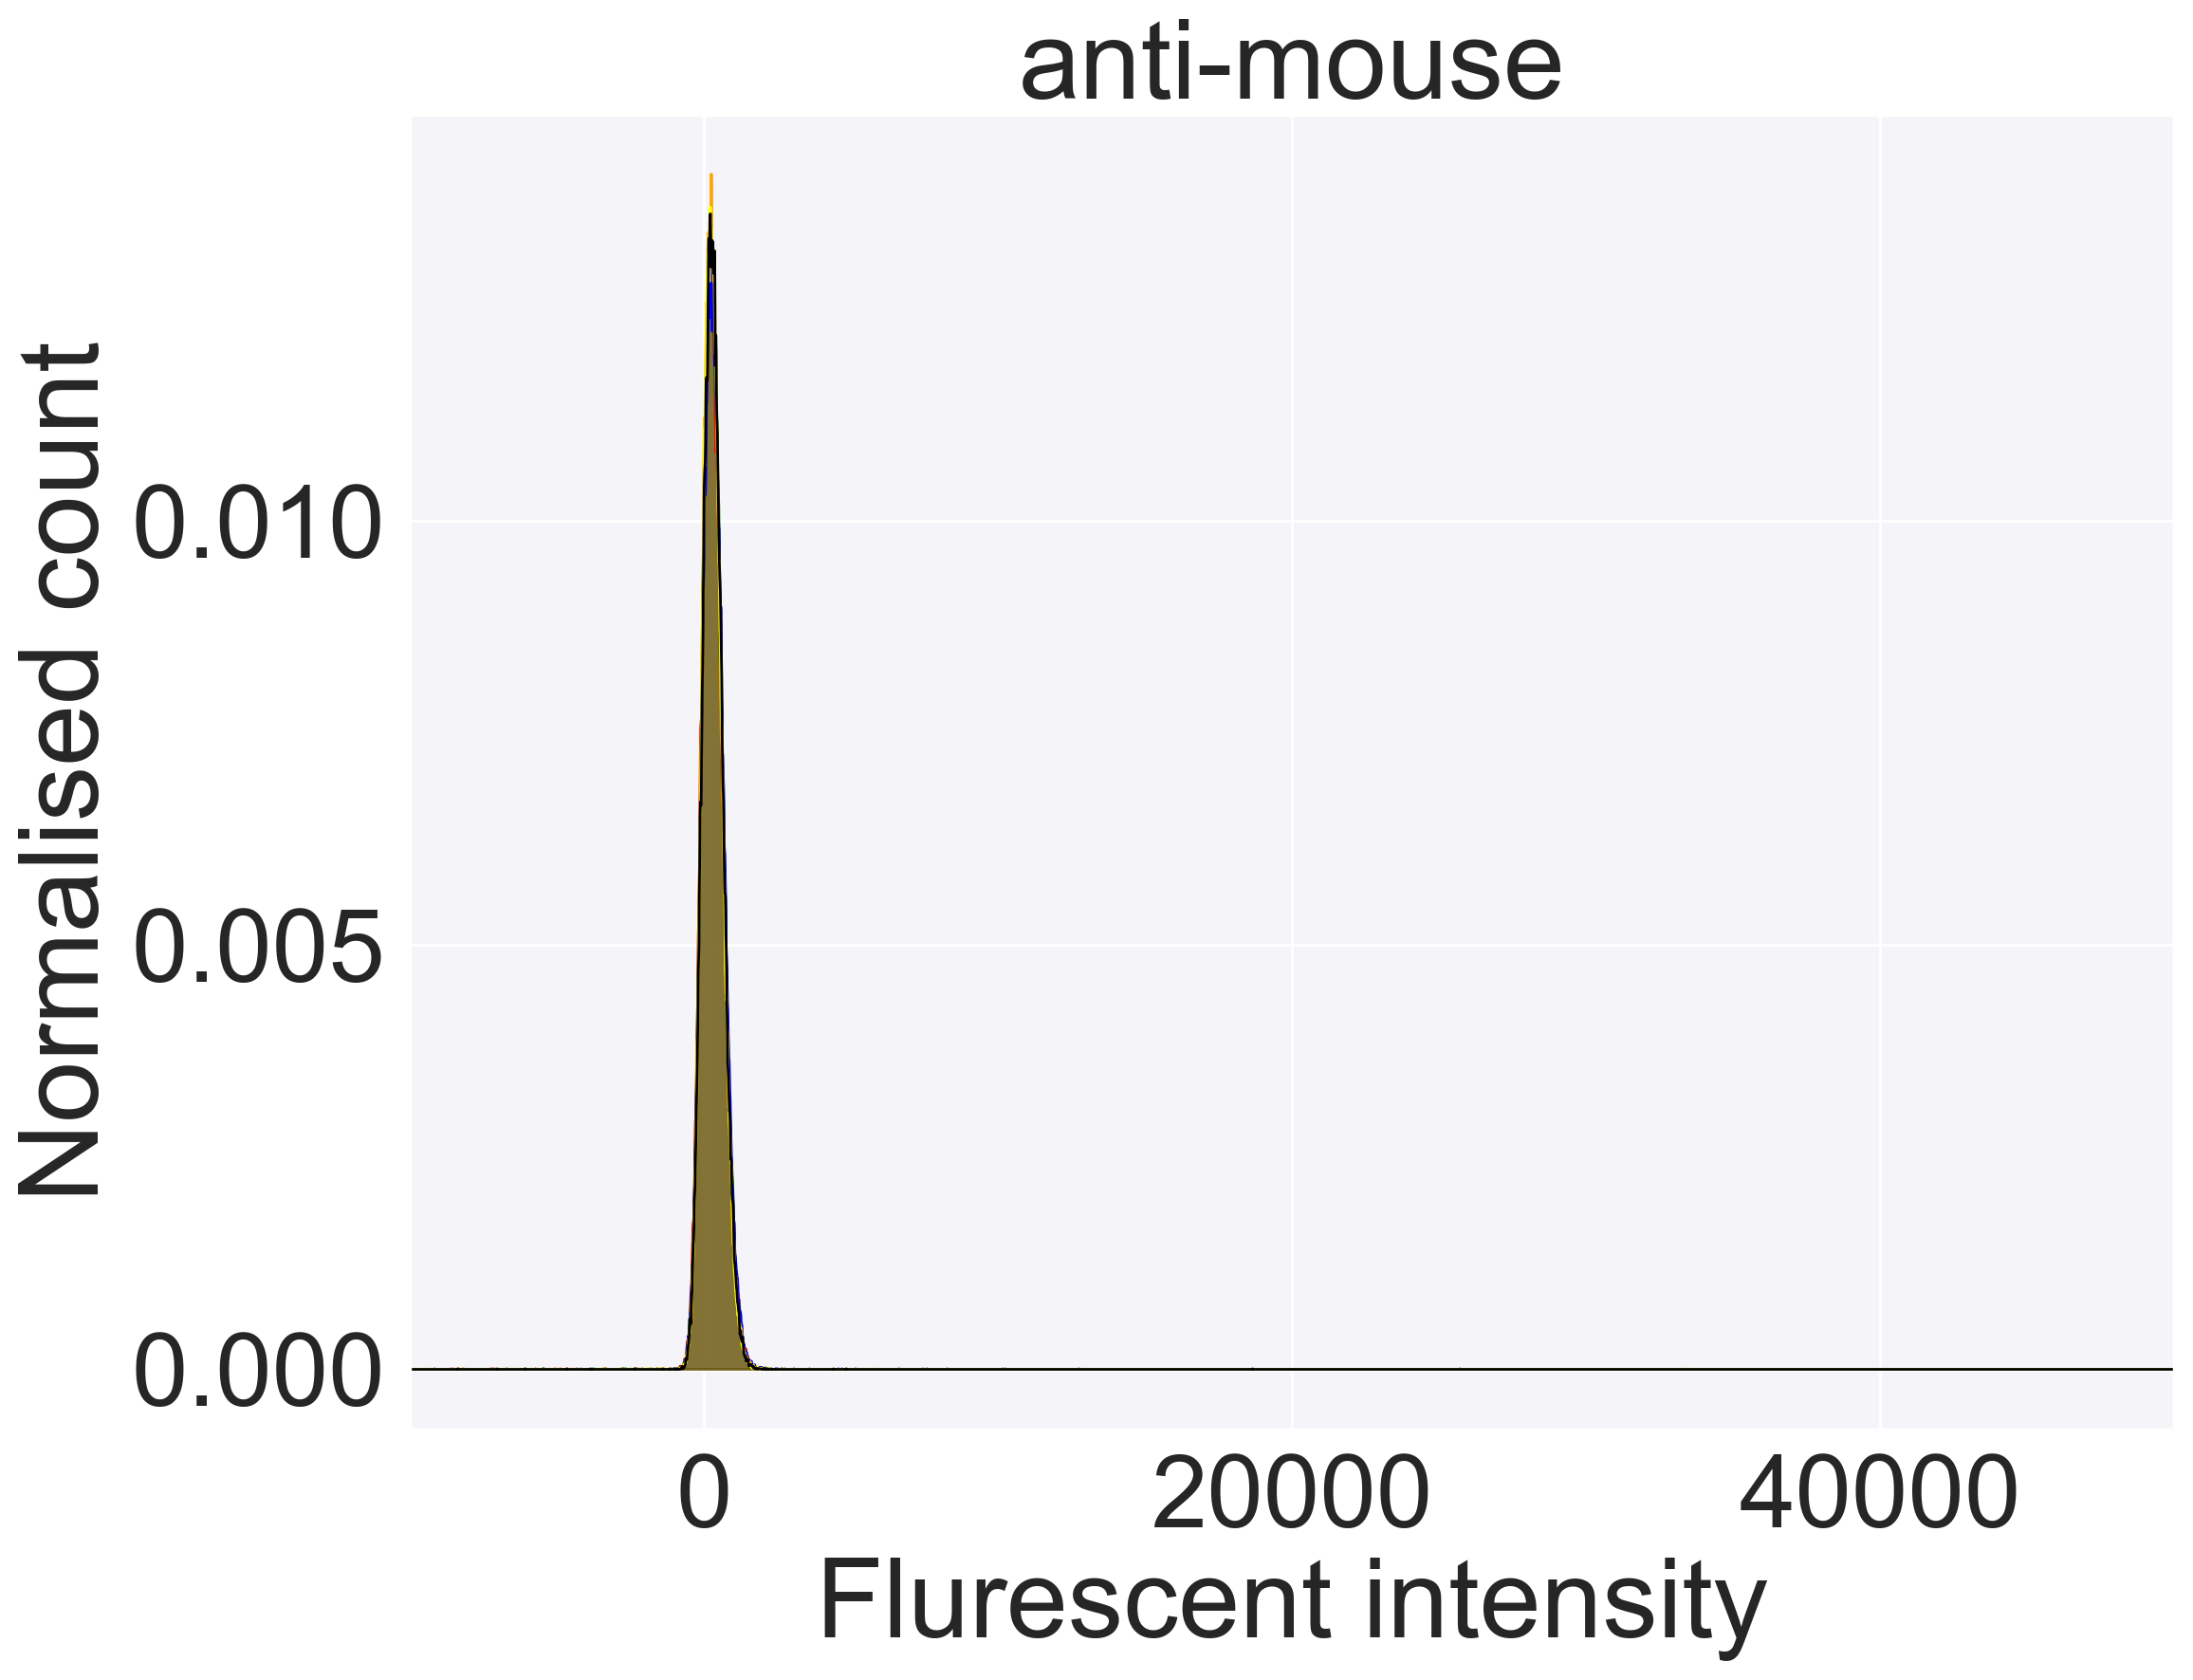

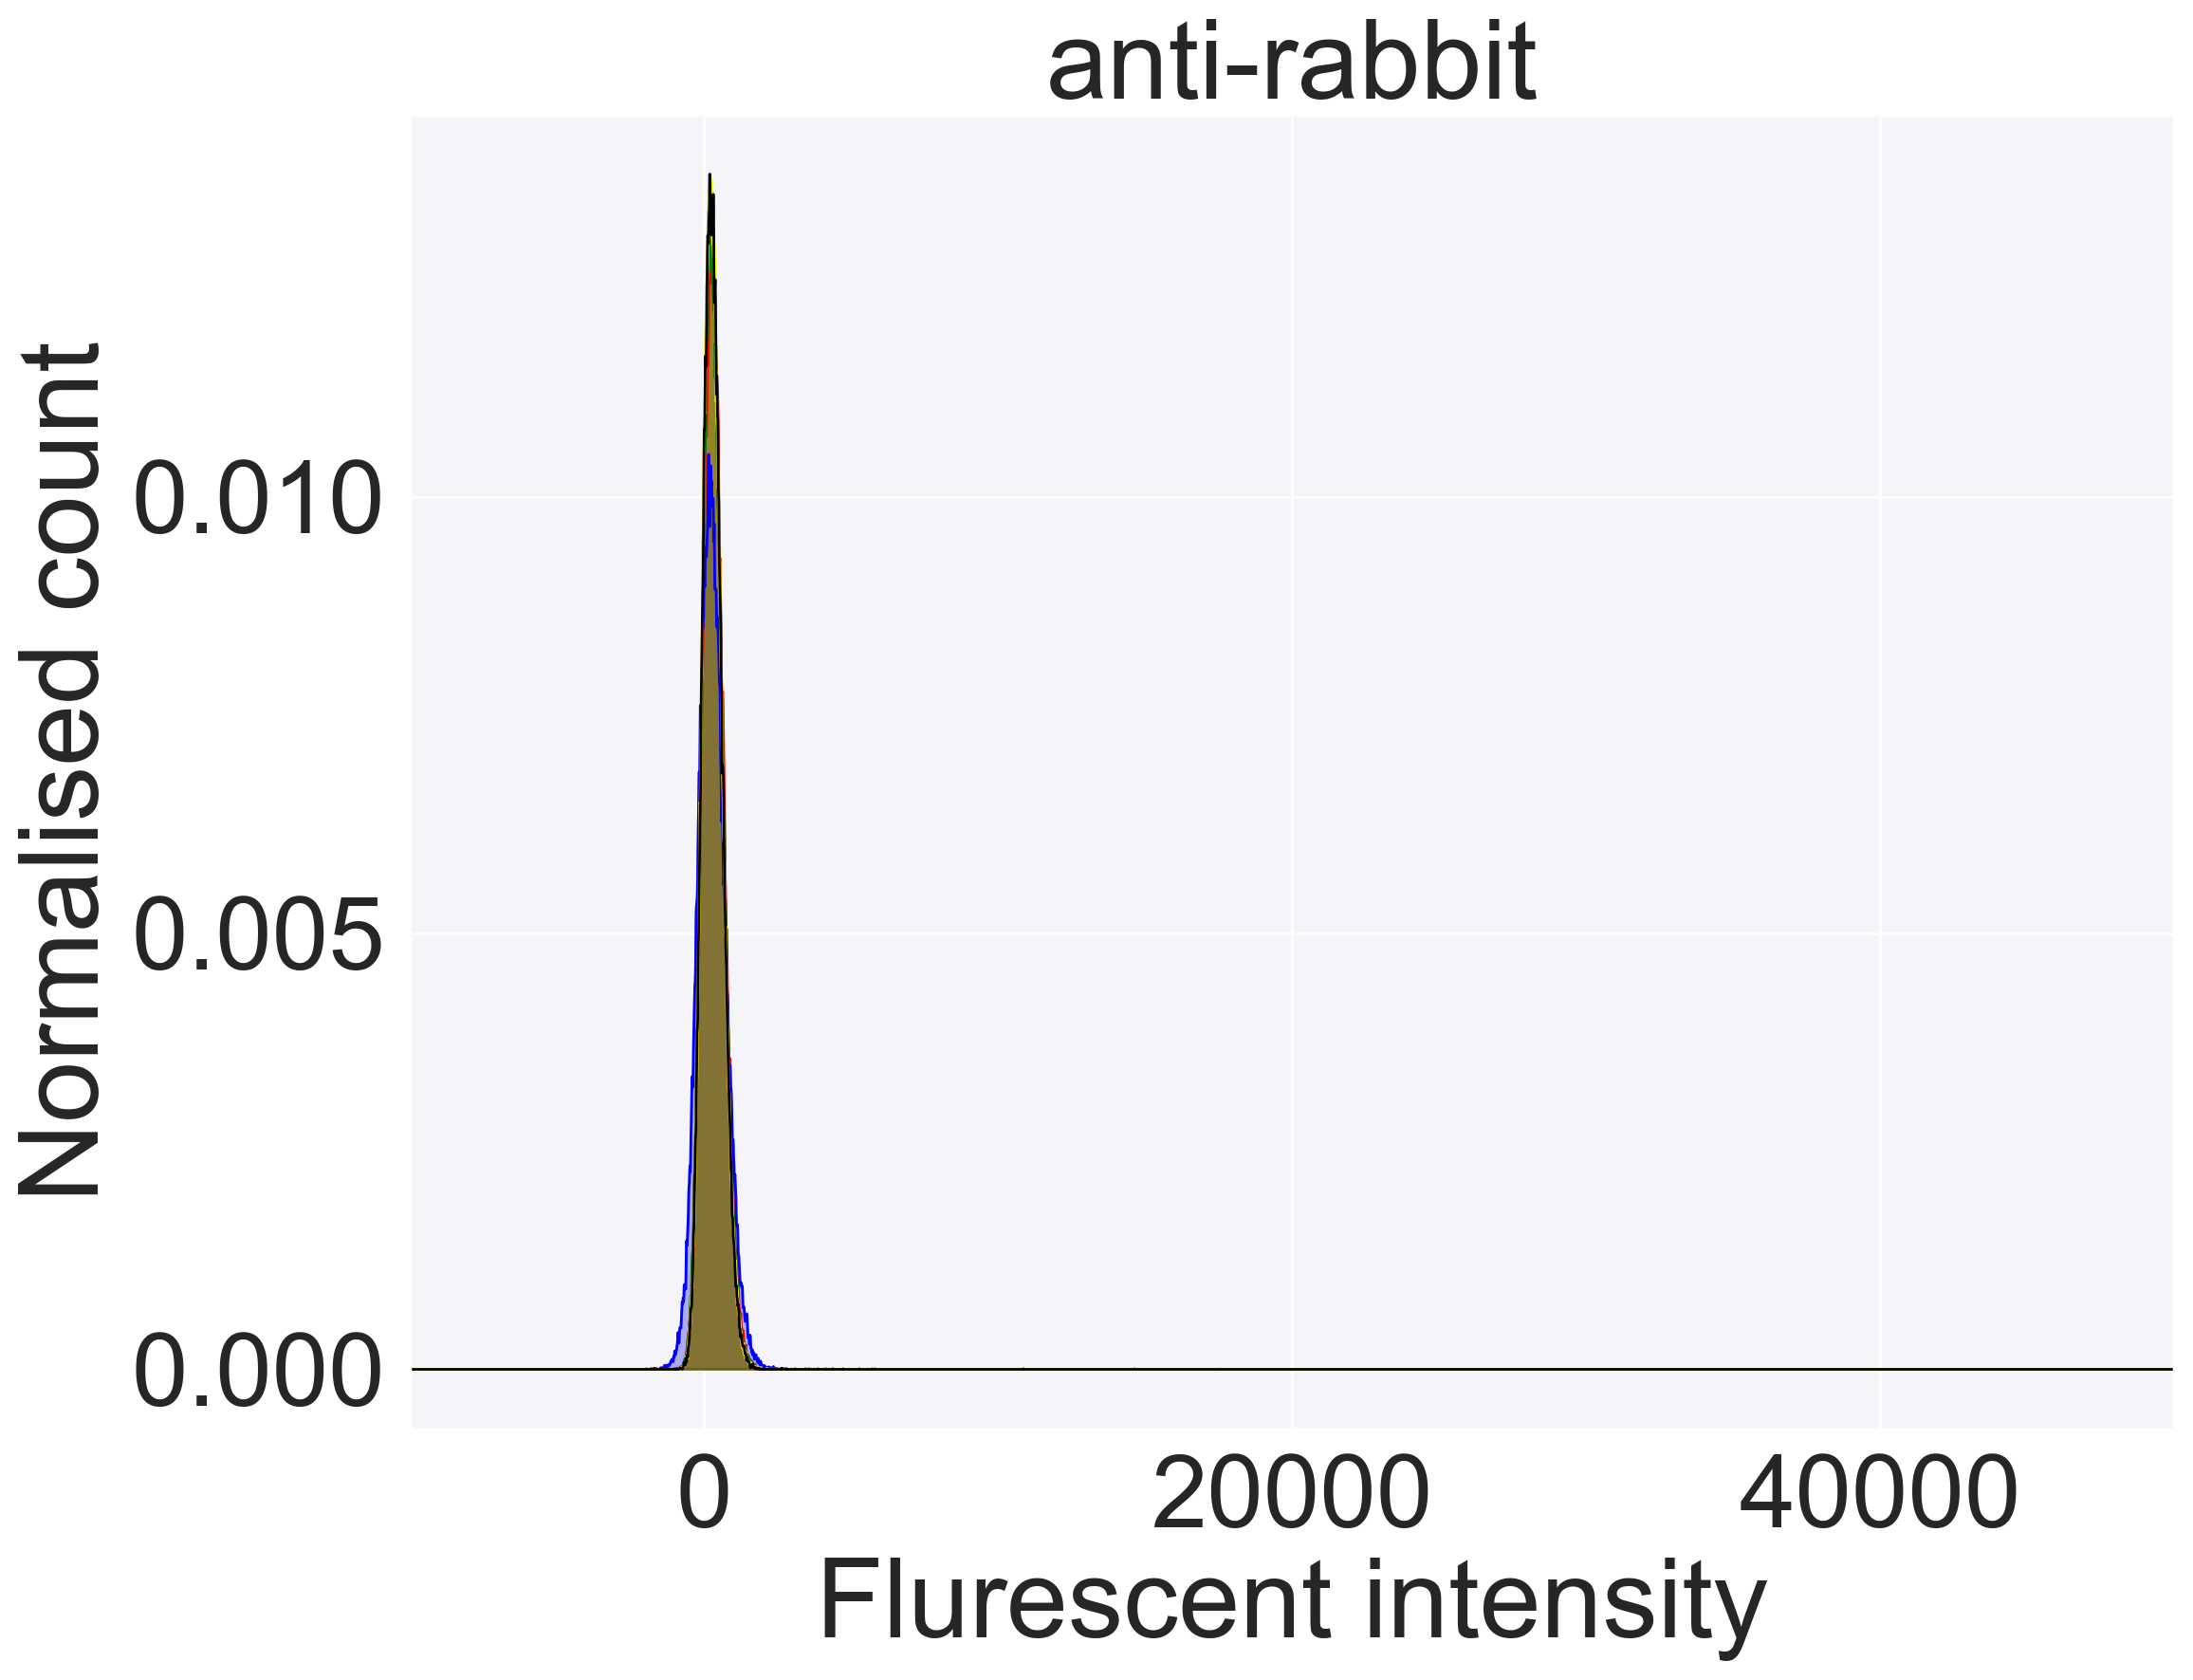

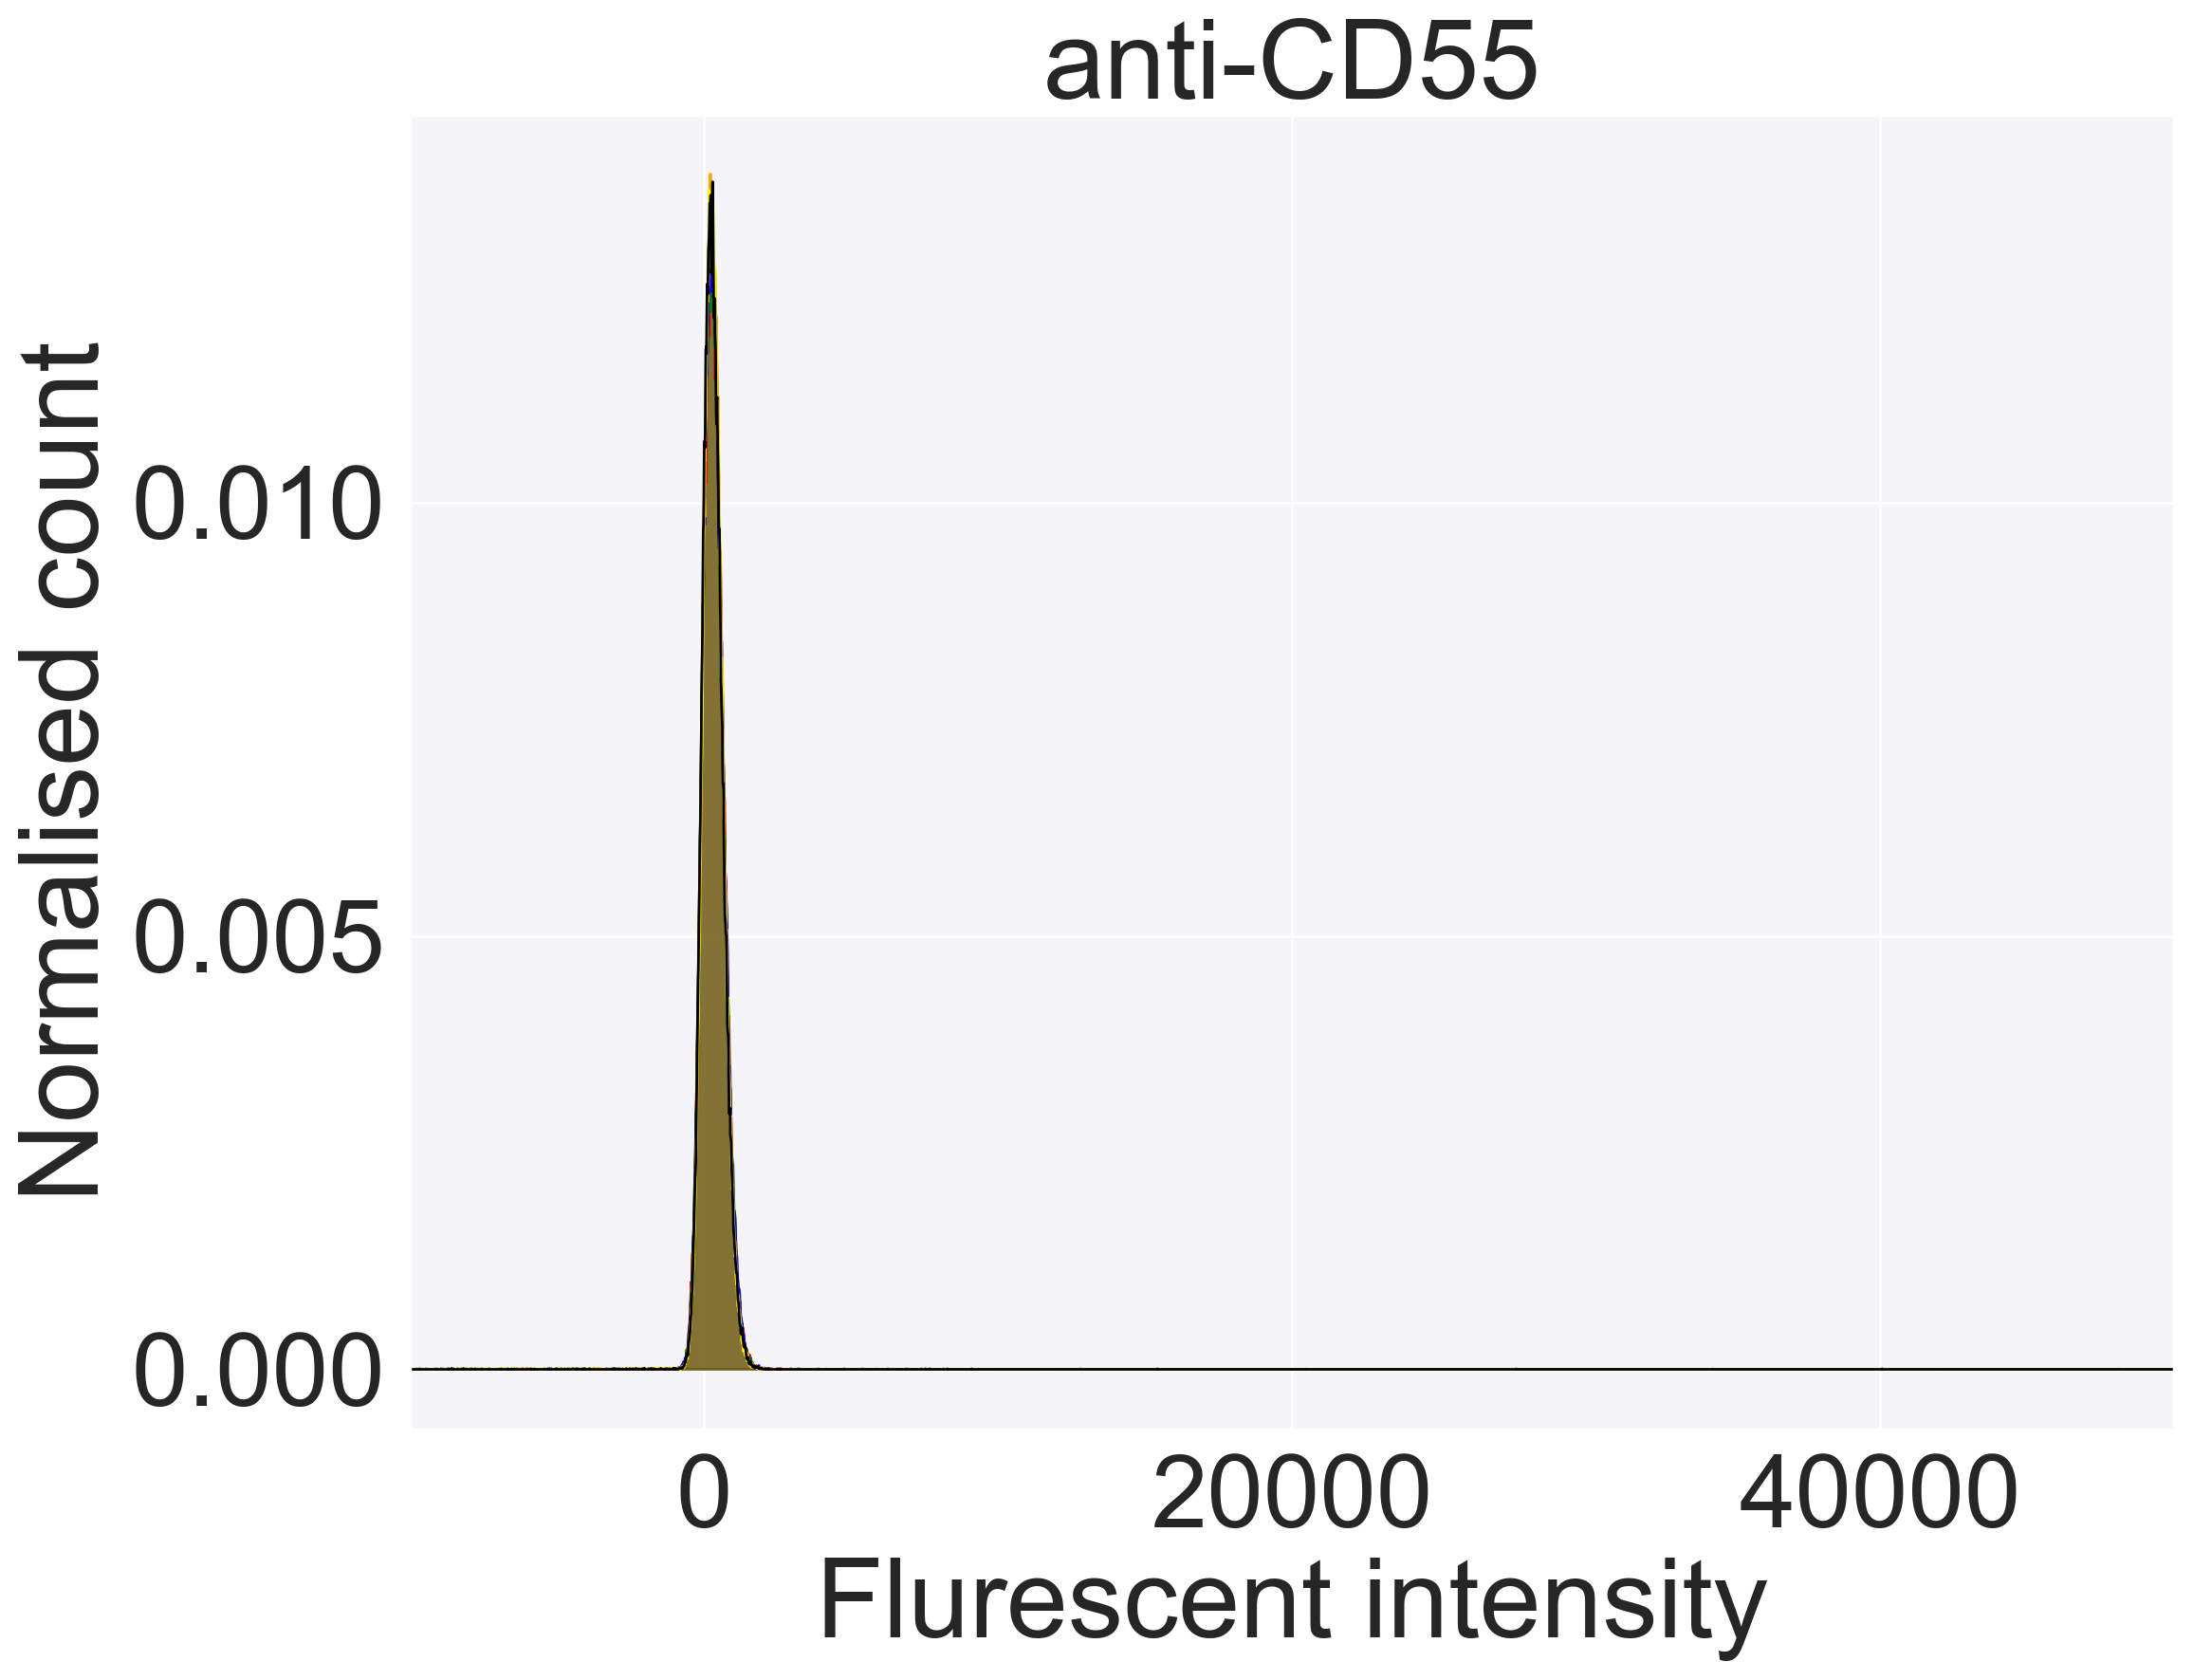

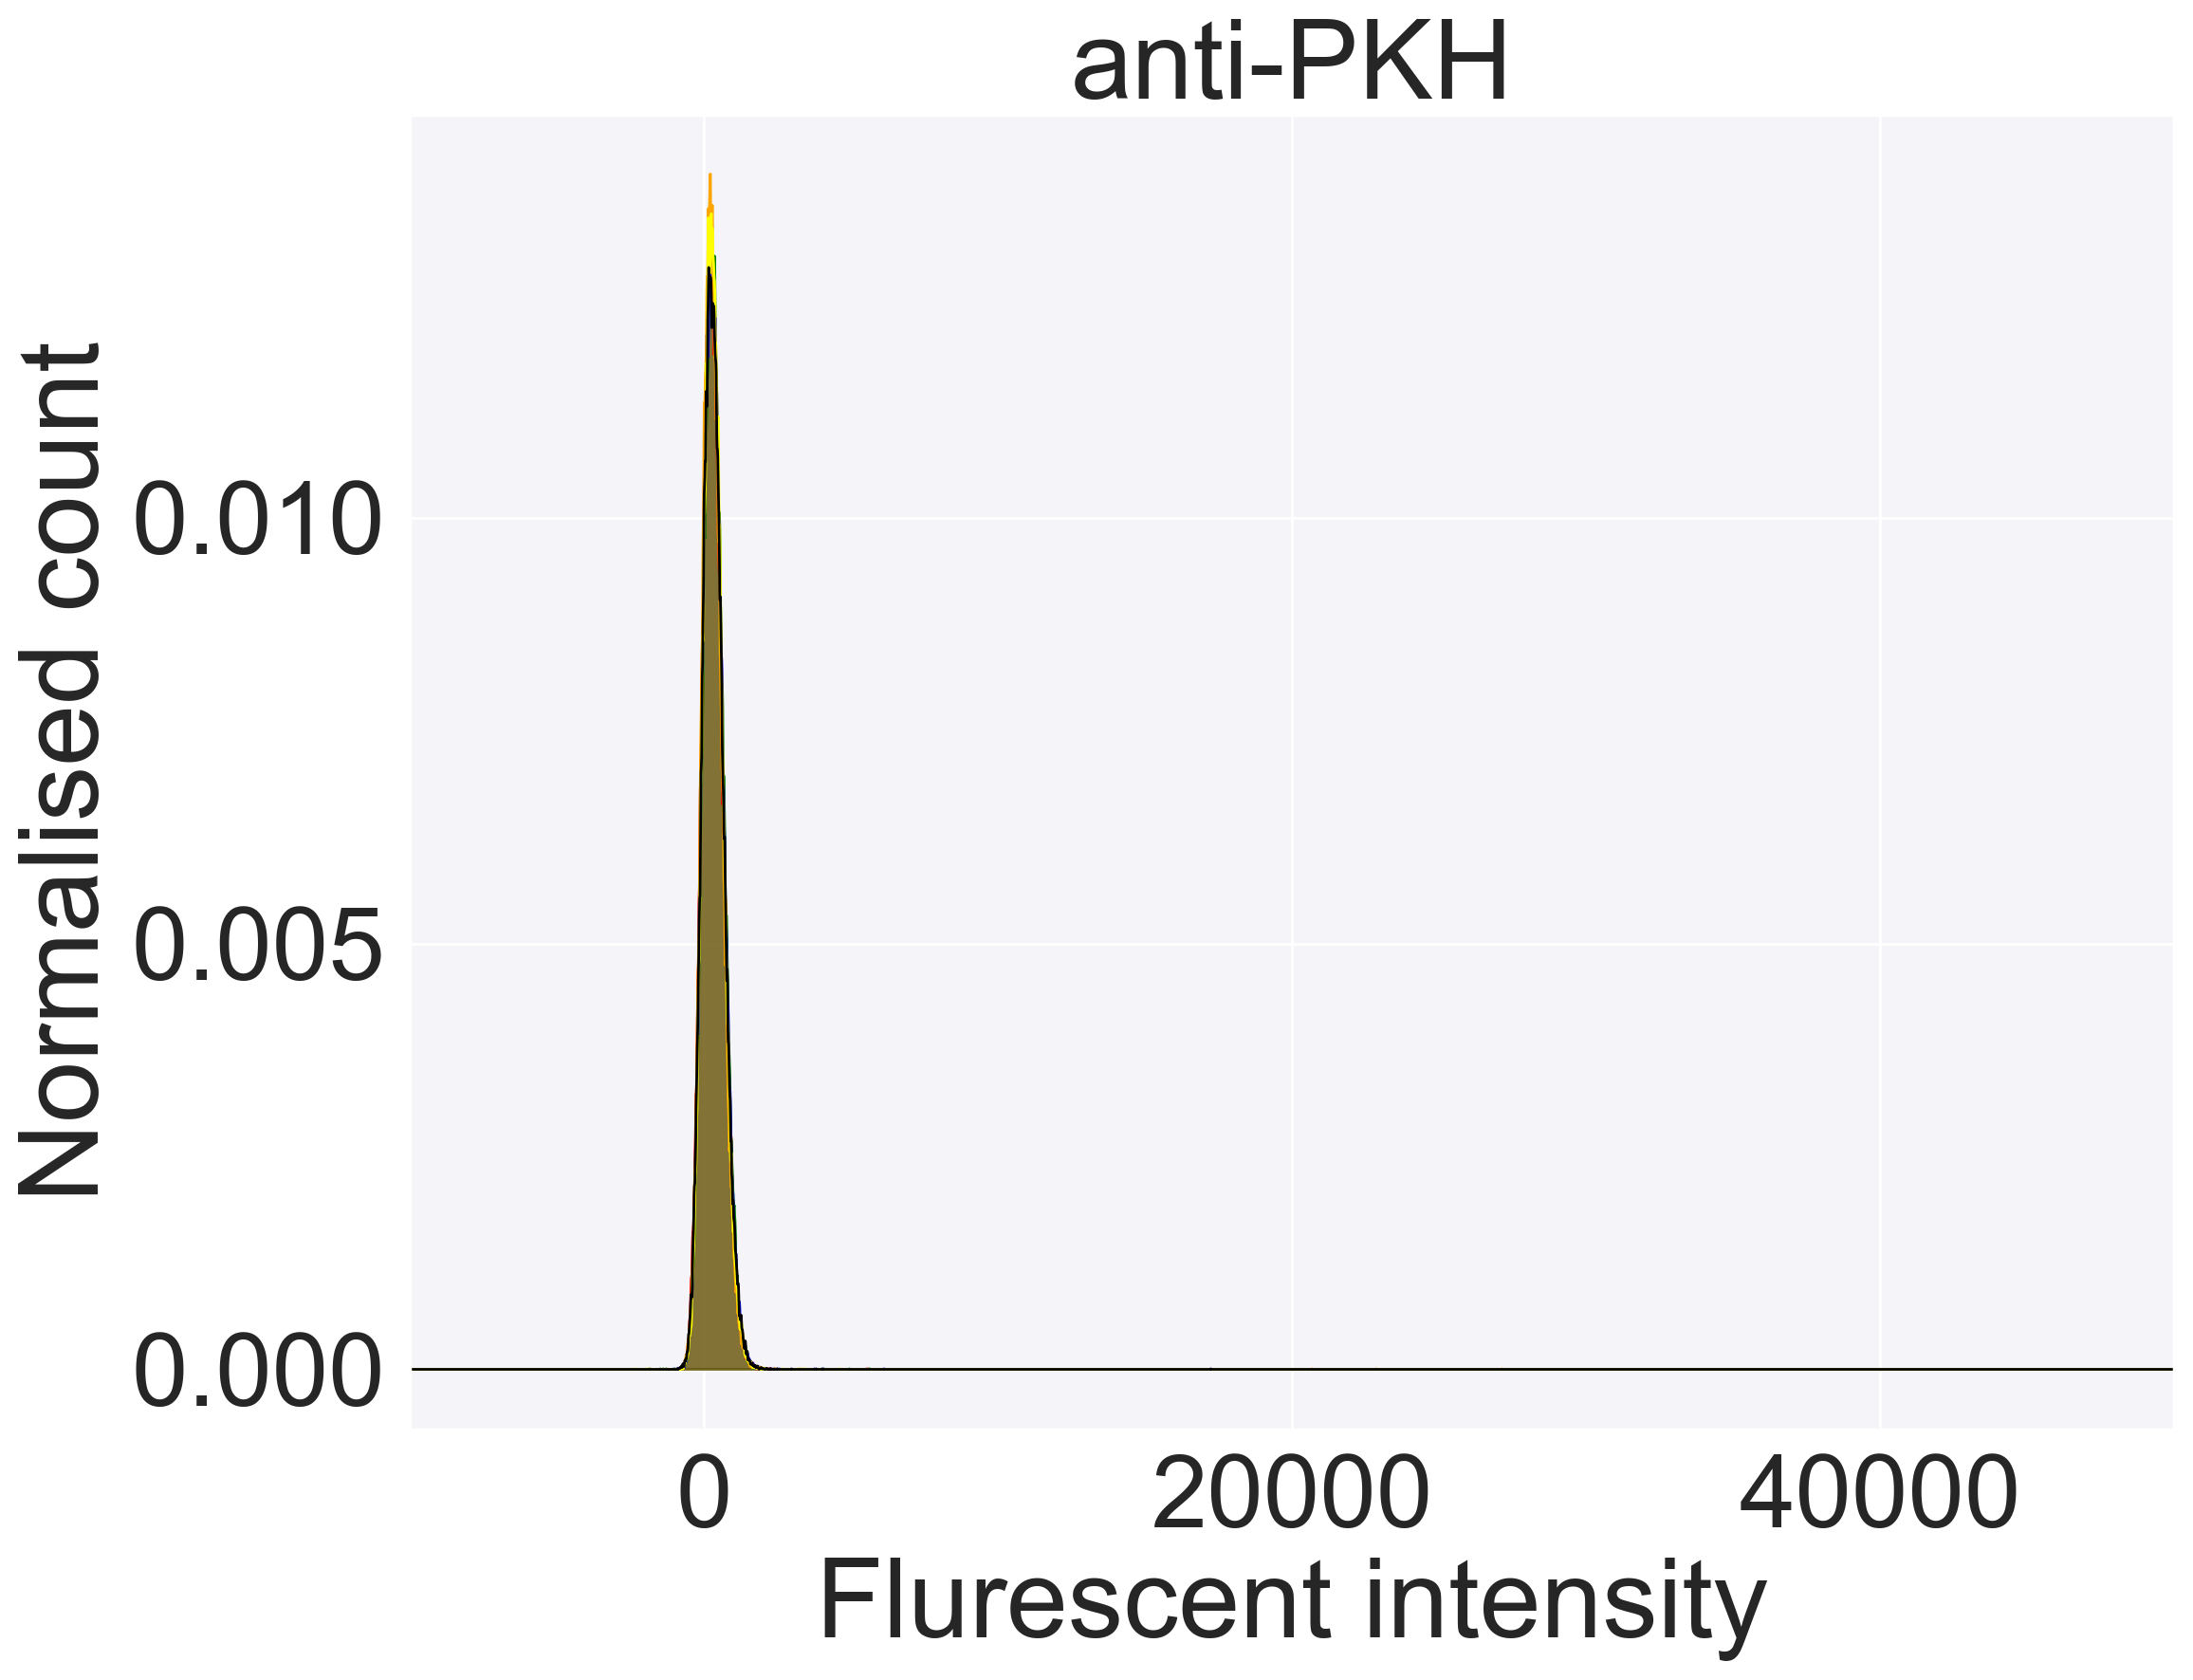

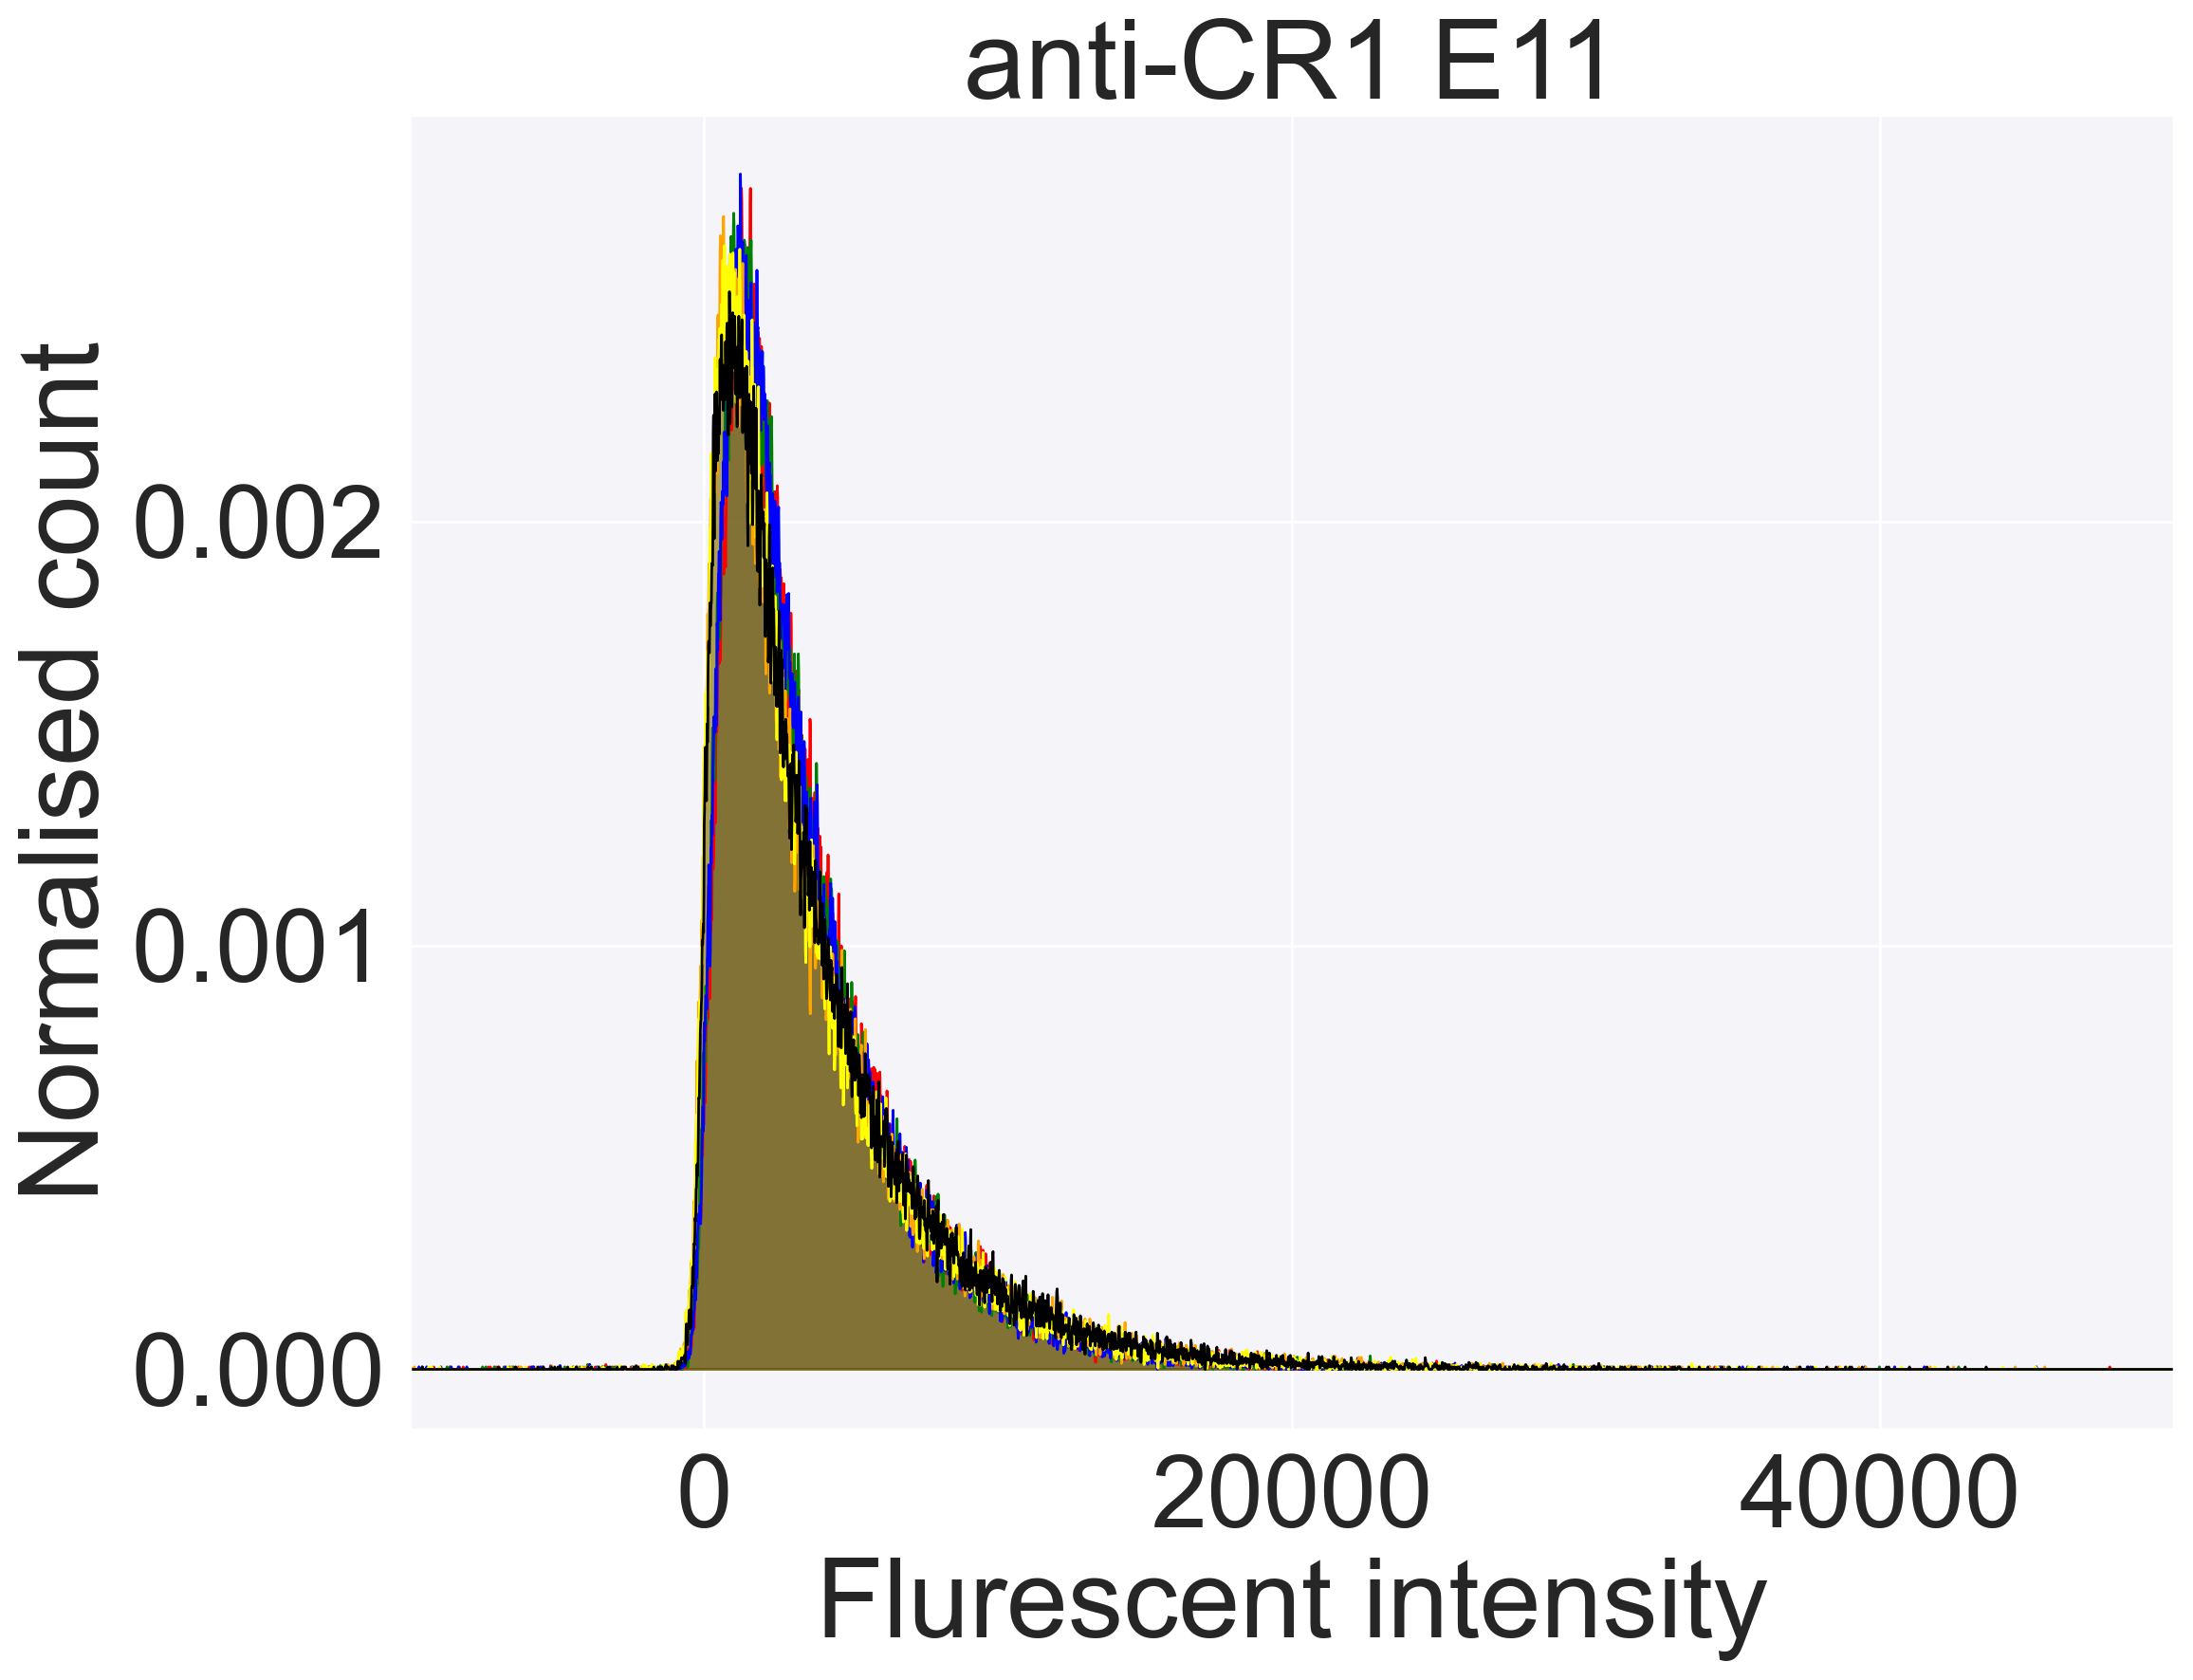

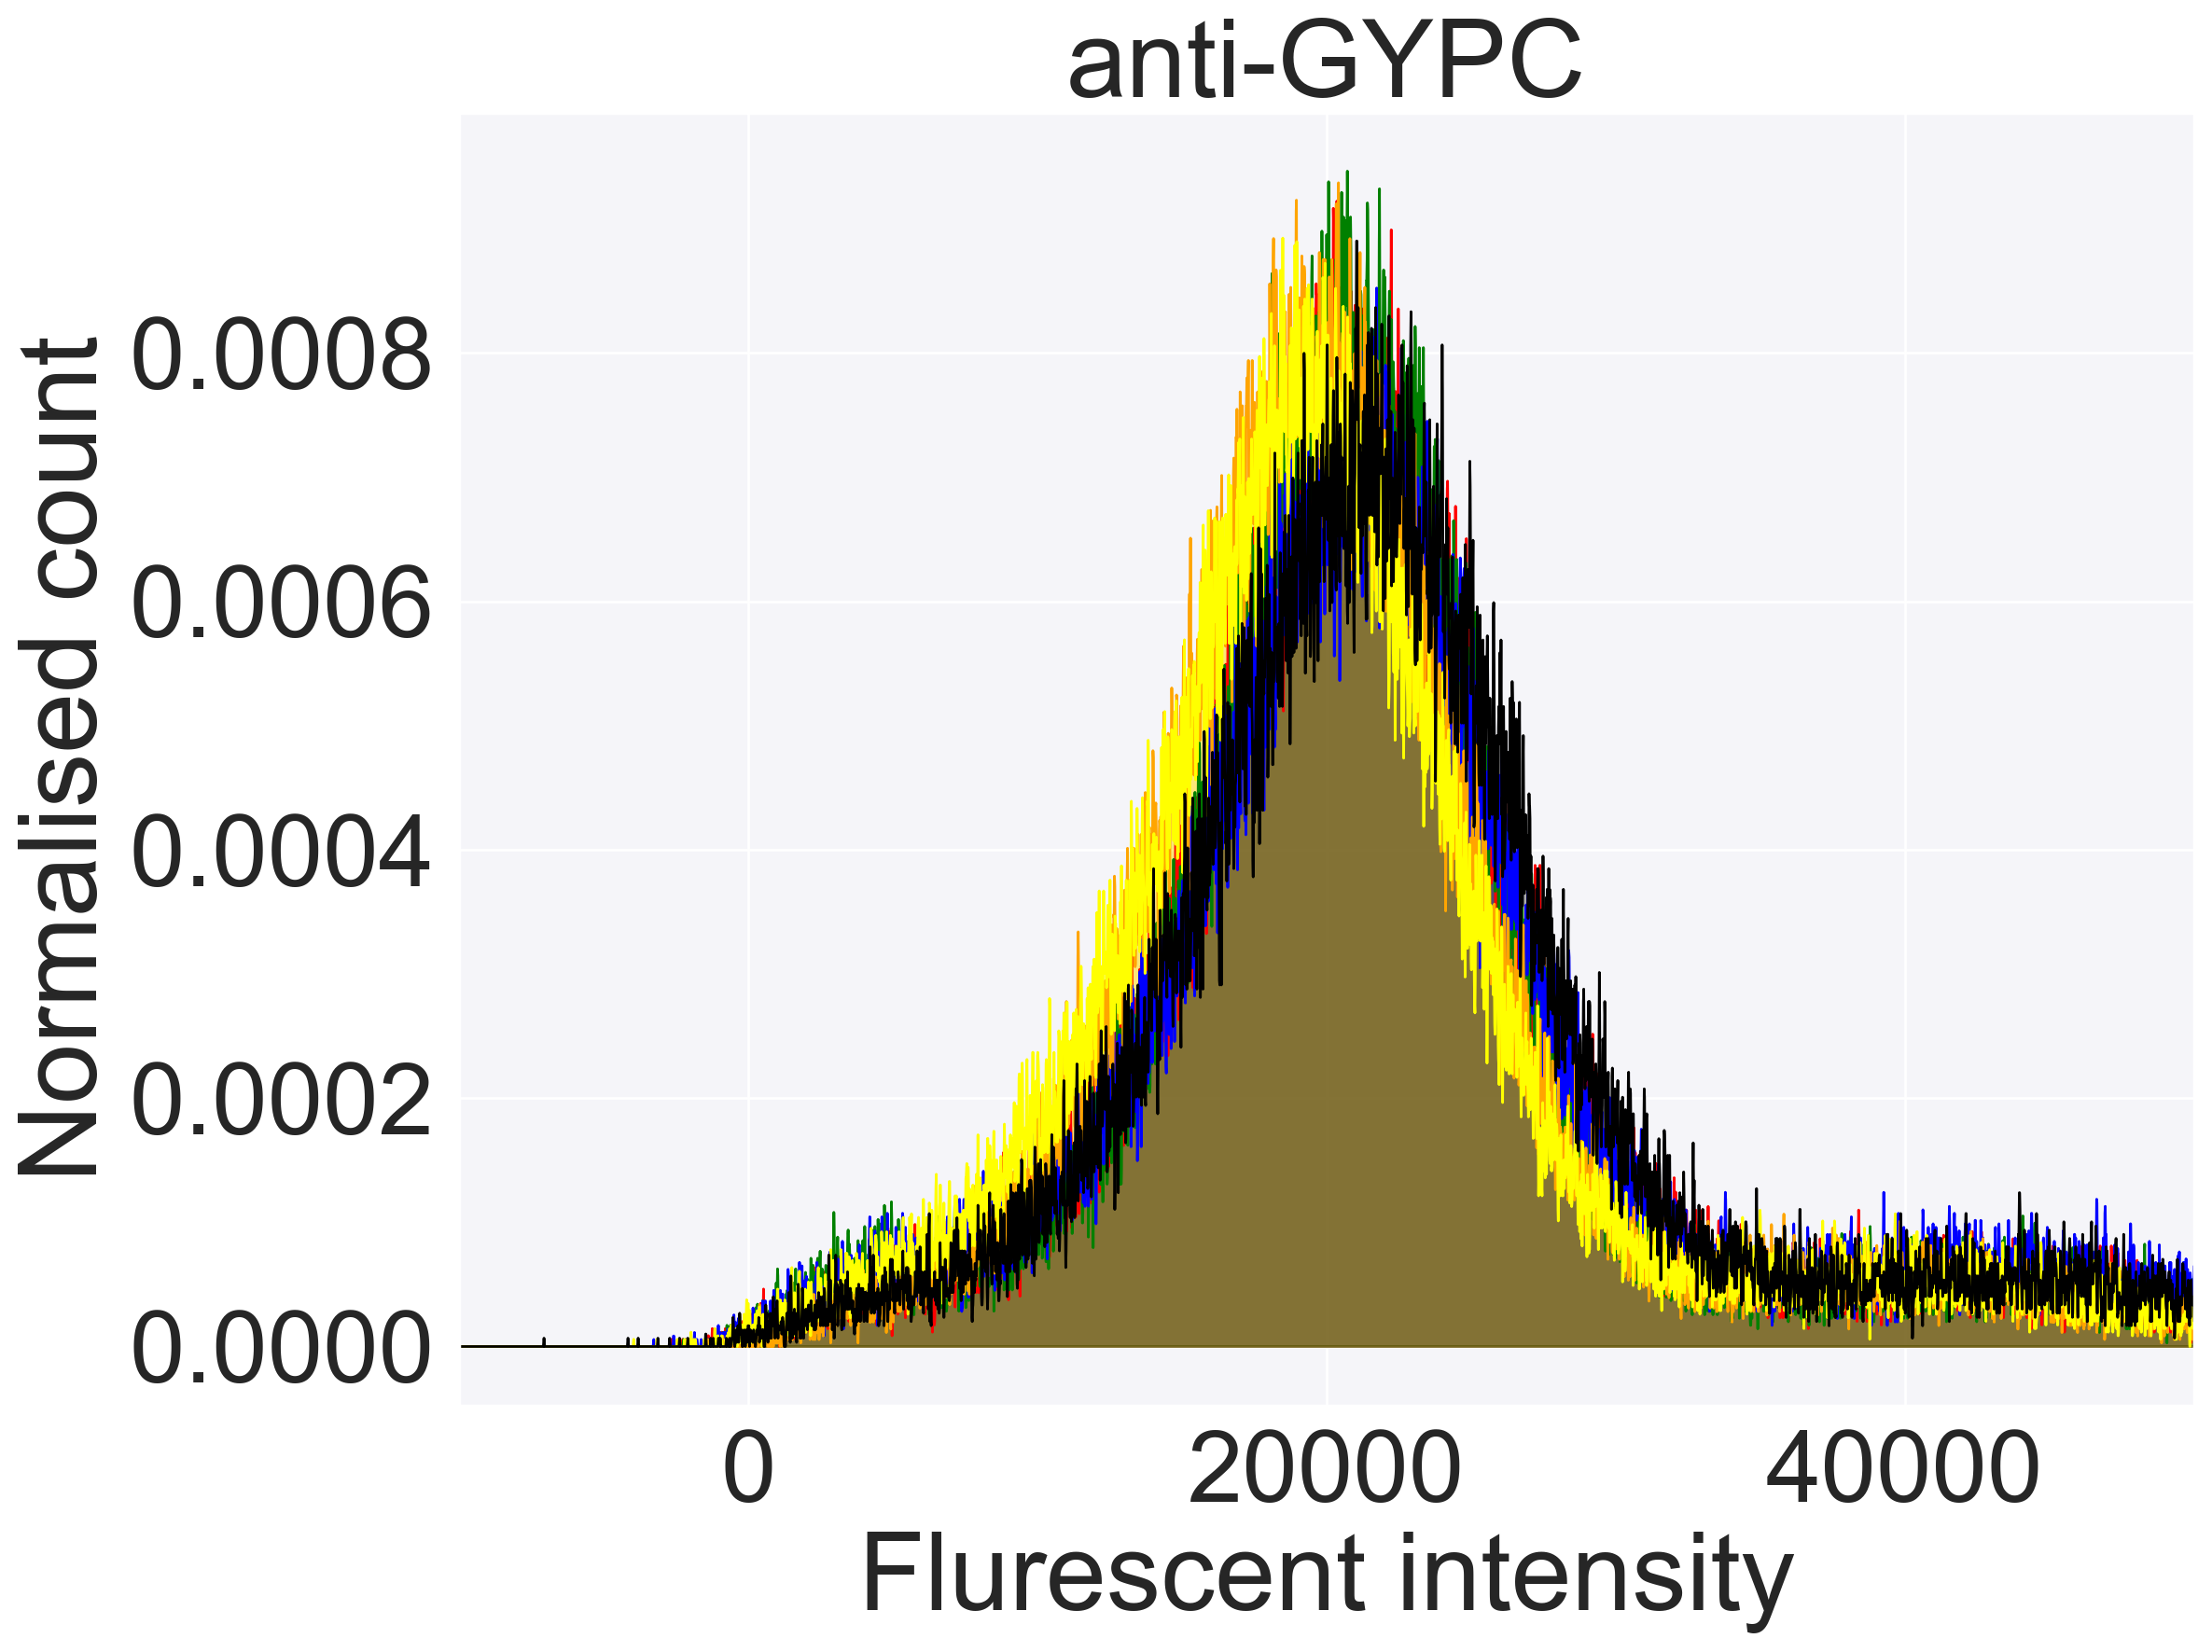

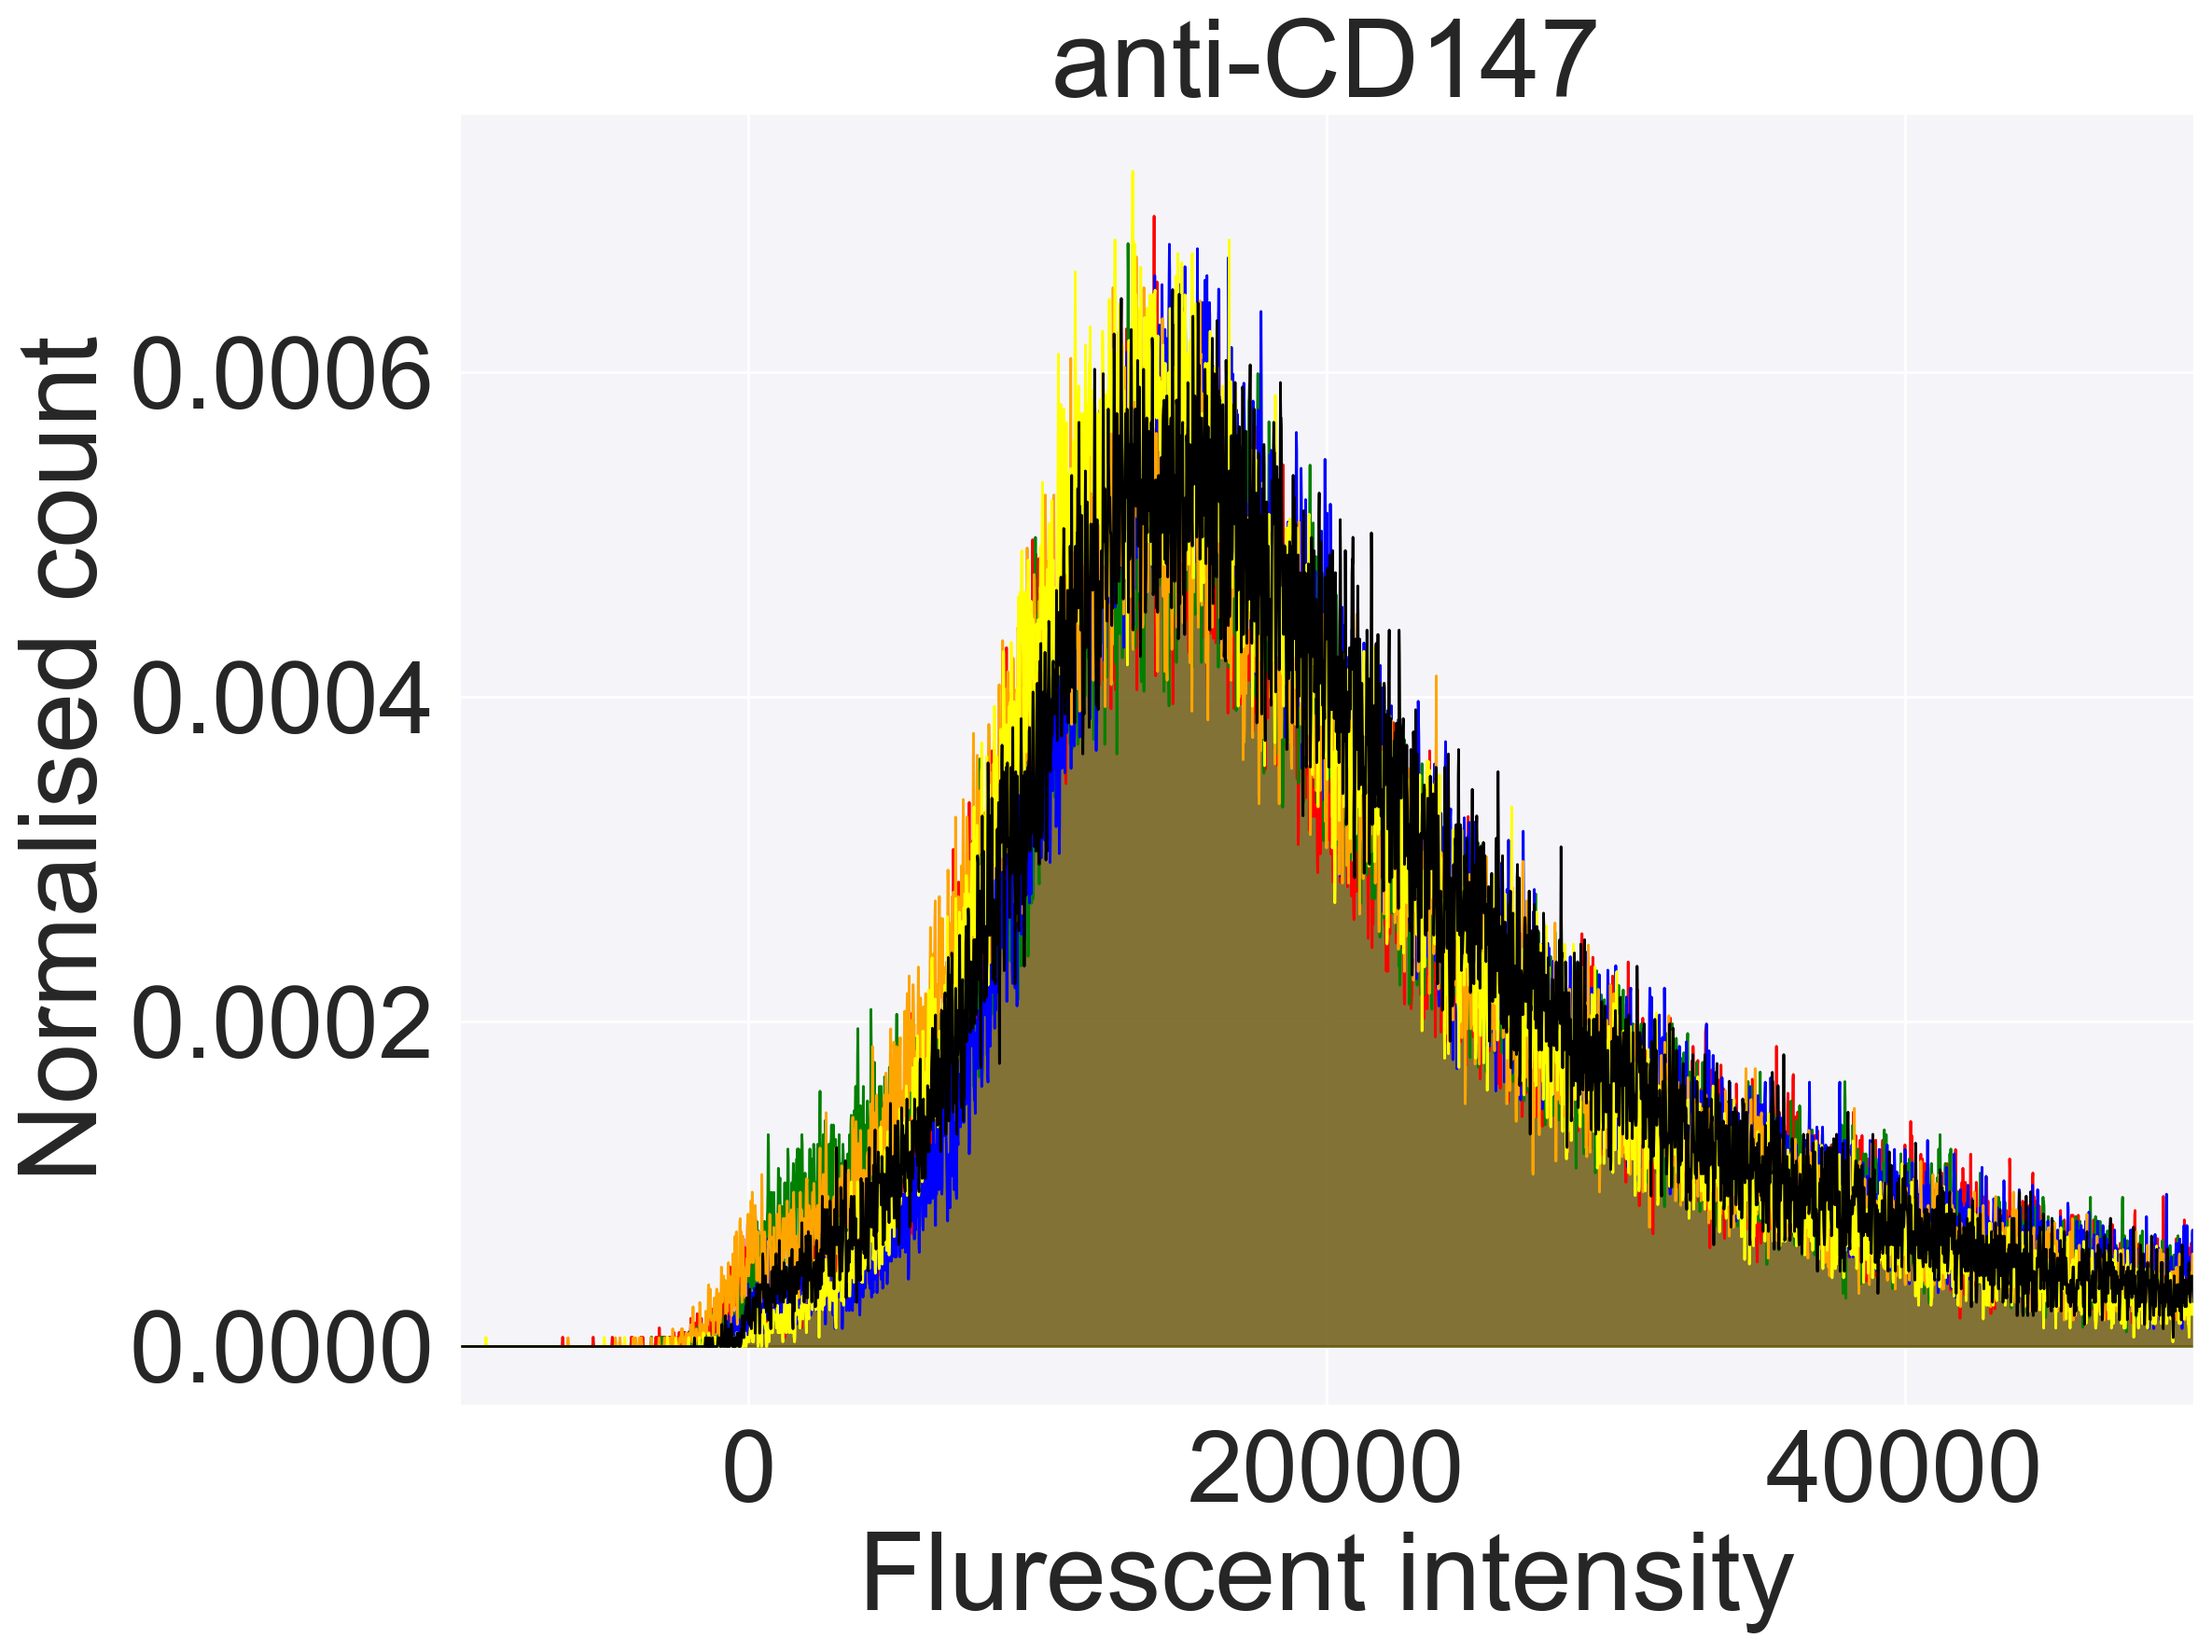

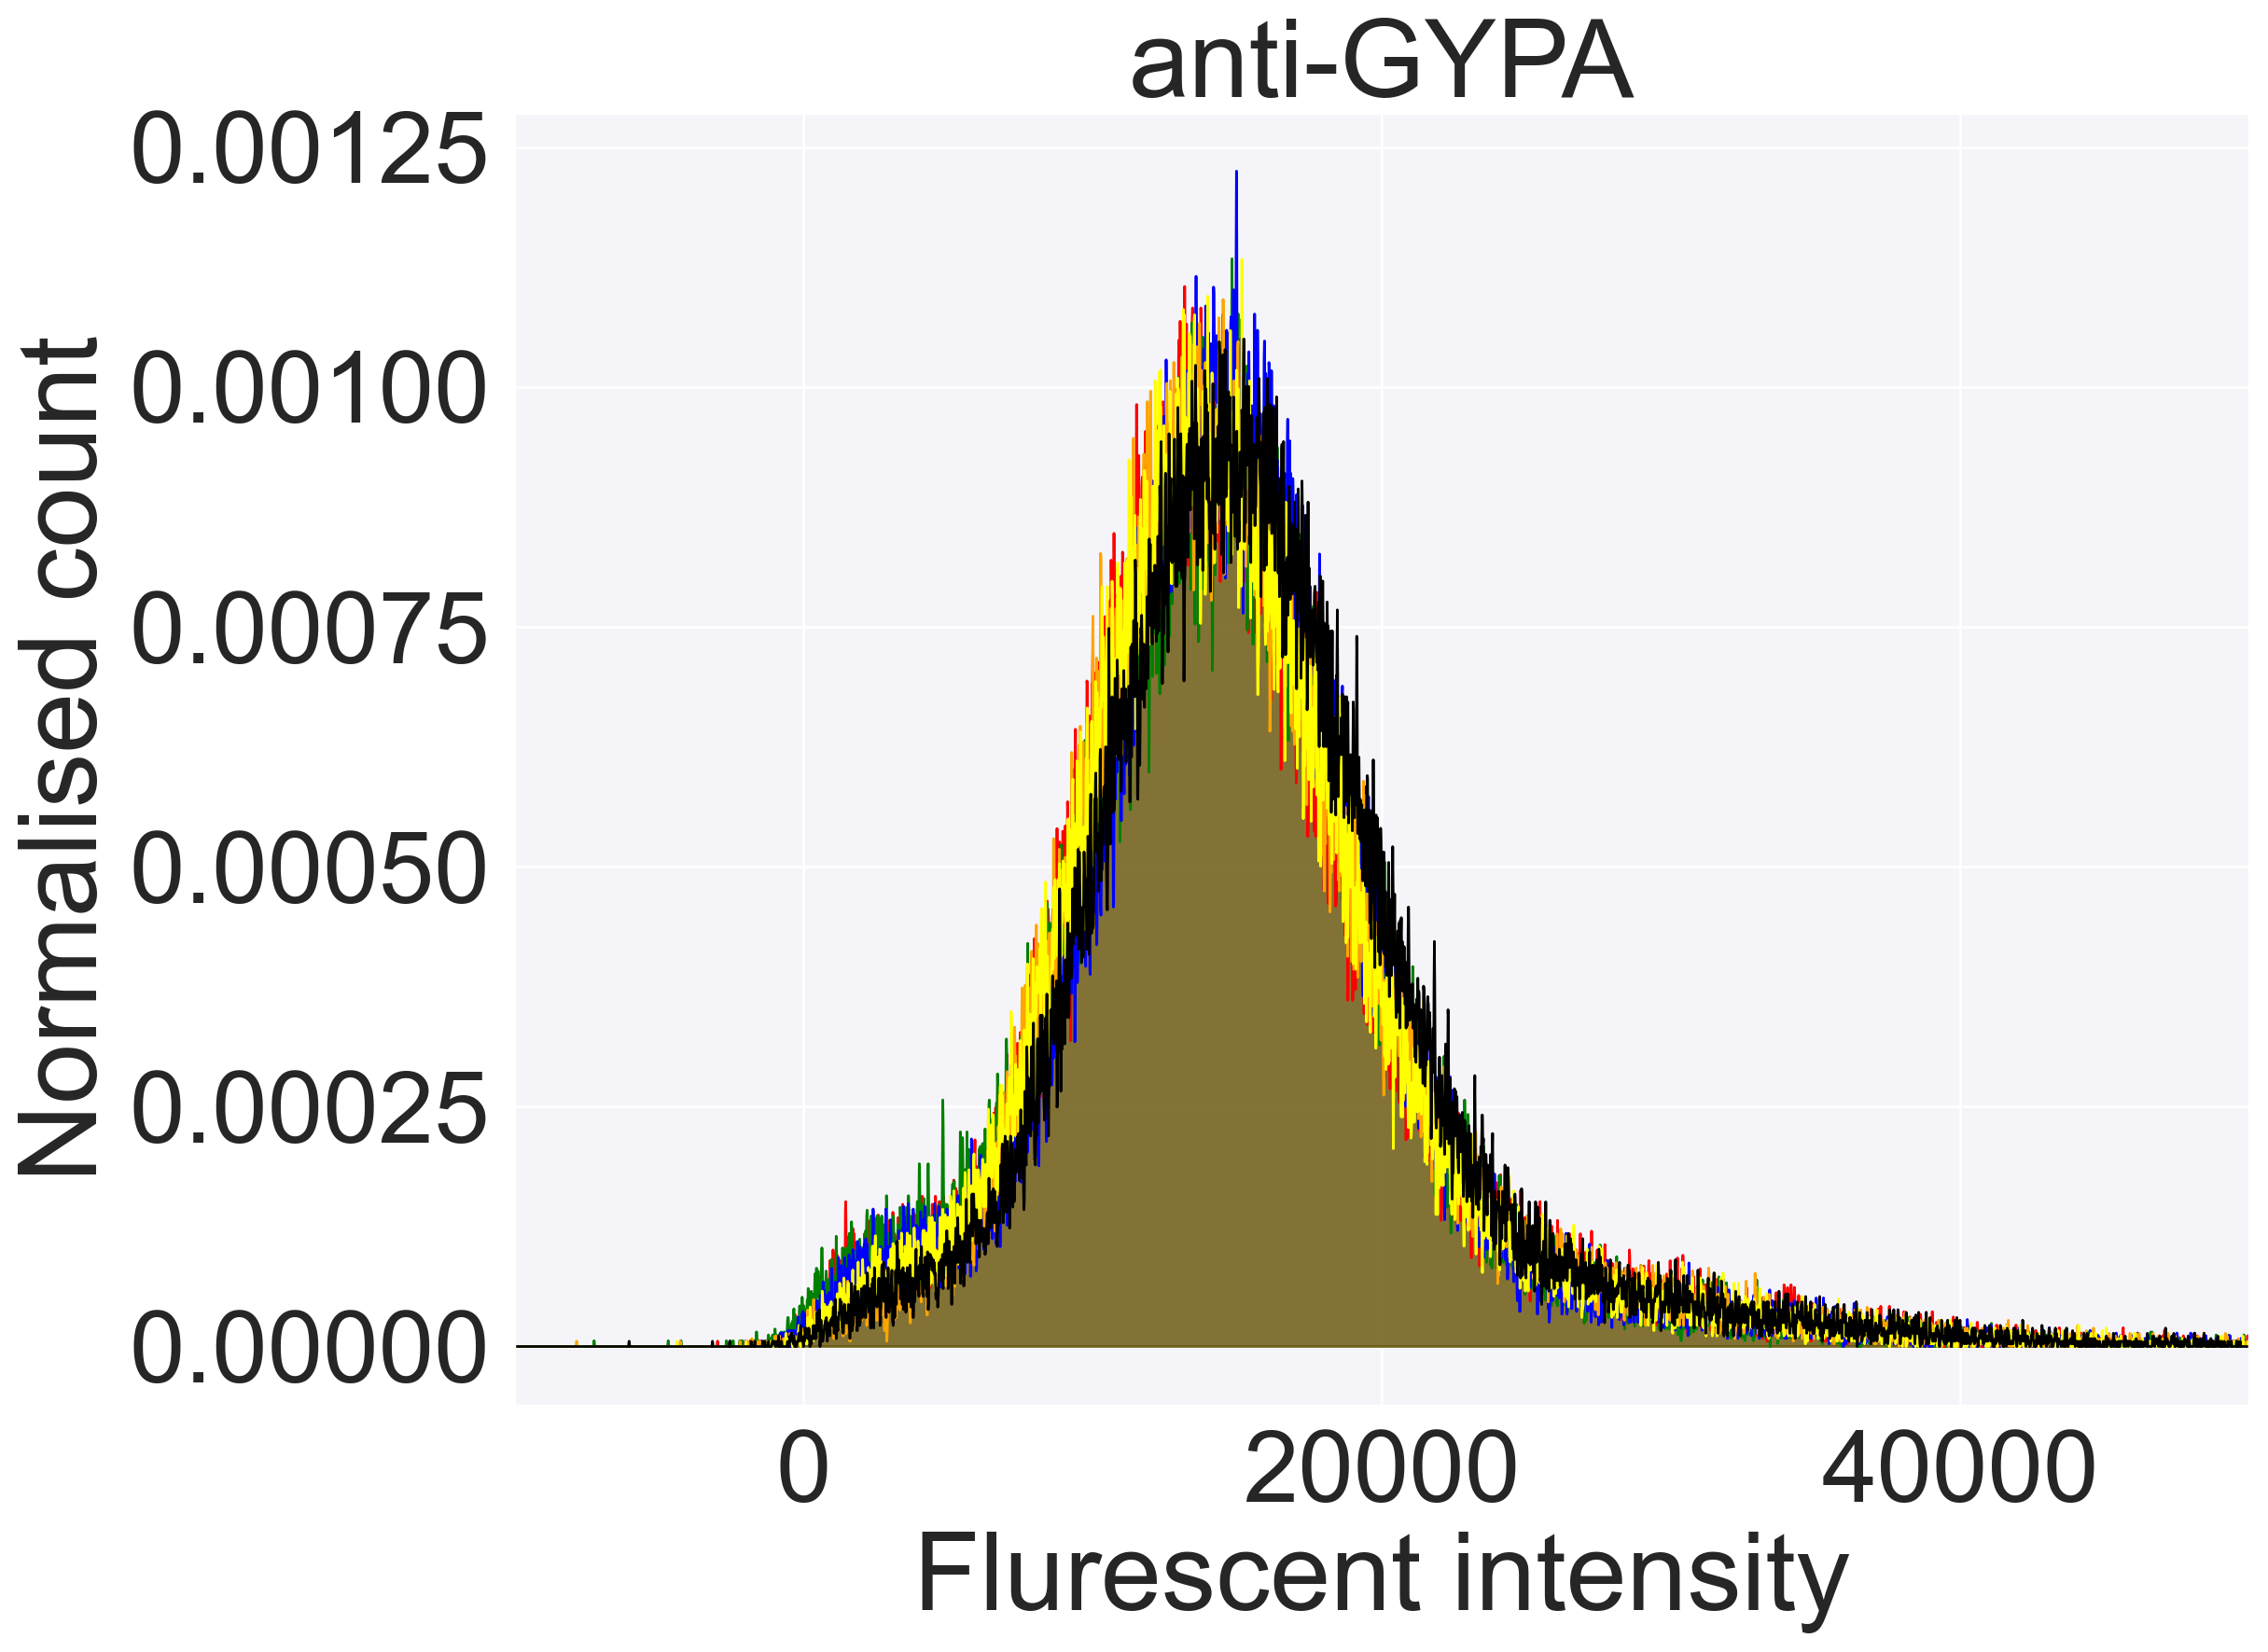

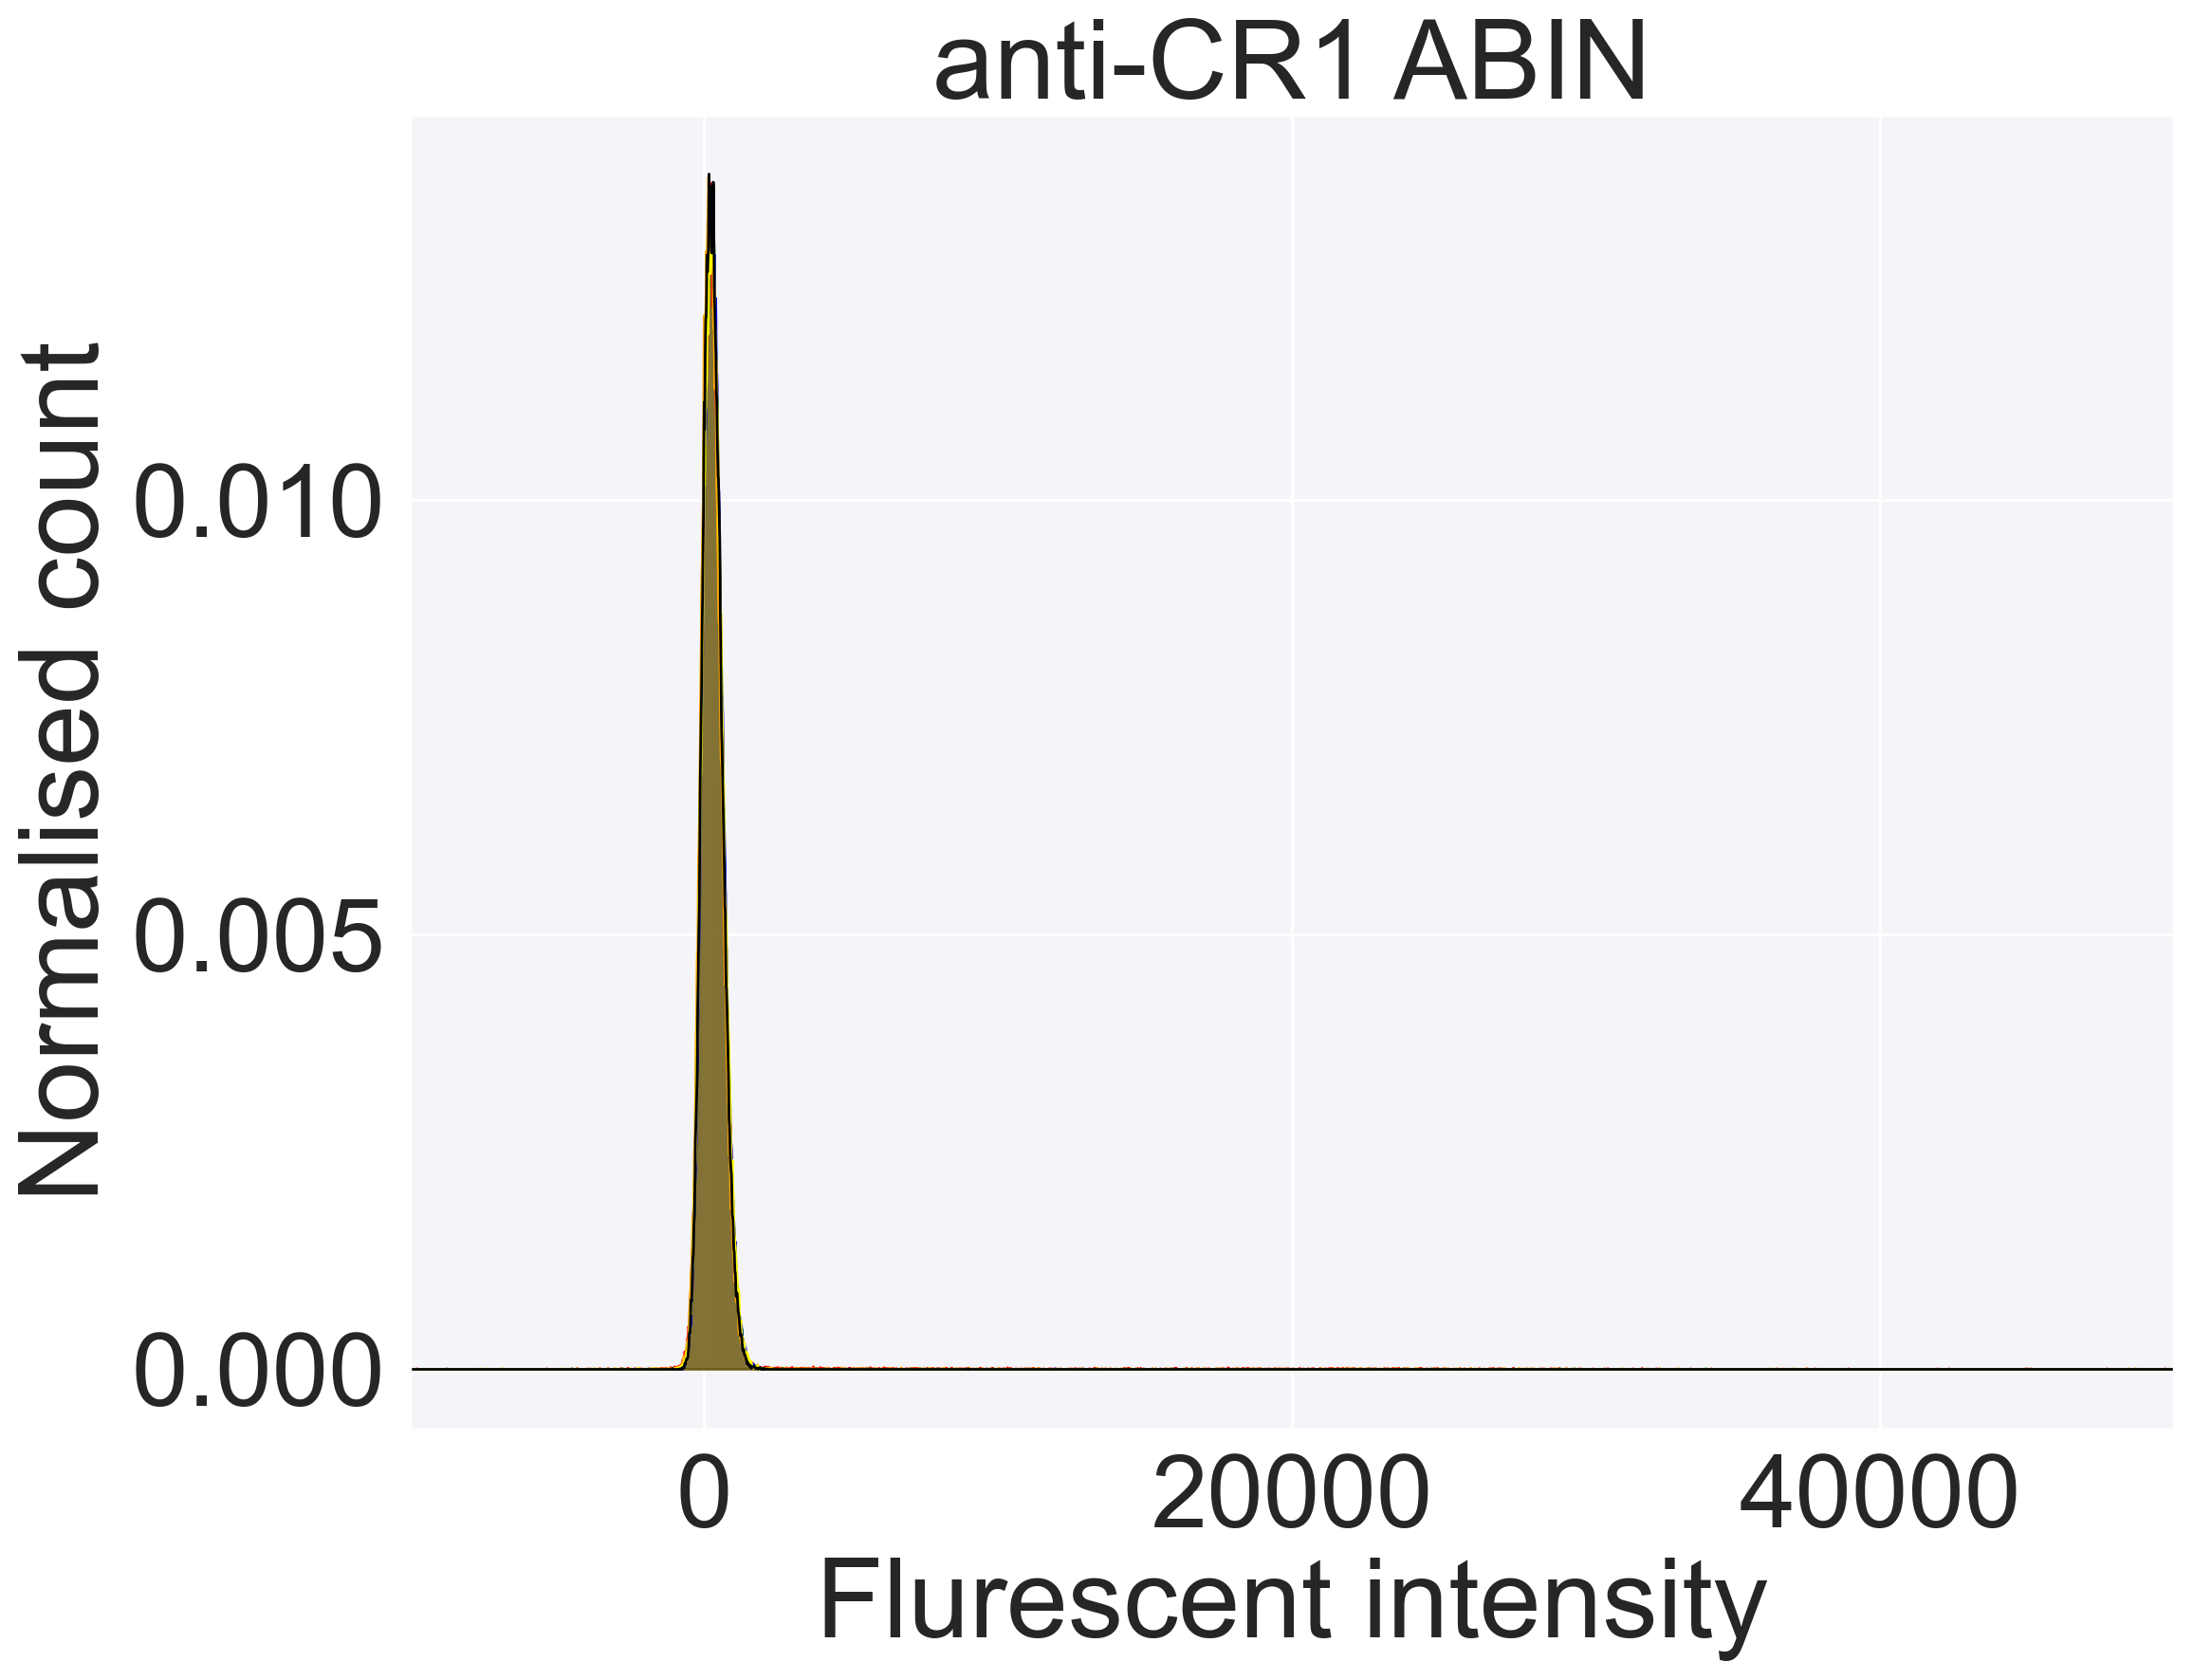

In [19]:
repeat_colors = {
    'repeat 1': 'red', 
    'repeat 2': 'green', 
    'repeat 3': 'blue',
    'repeat 4': 'orange',
    'repeat 5': 'yellow',
    'repeat 6': 'black',
}

for condition, repeats in data.items():
    histograms = [r['hist_norm'] for r in repeats]
    plot_smooth_histogram(histograms, repeat_colors.keys(), title=condition, xlim=(-1e4, 5e4), colors=repeat_colors)

In [20]:

print(path)
# s = FlowCal.io.FCSData('FCFiles/Data001.fcs')
s.channels

C:/Users/Emma Jones/OneDrive - University of Cambridge/Documents/My work/cambridge/Year 2/Rayner lab/Data/Invasion assay flow cytrometry/EEJR0153_2023.05.19 antibody binding assay correct


('Time',
 'FSC-A',
 'SSC-A',
 'BL1-A',
 'FSC-H',
 'SSC-H',
 'BL1-H',
 'FSC-W',
 'SSC-W',
 'BL1-W')